<a href="https://colab.research.google.com/github/varshini0317/Pharmaceutical-Sales-Forecasting-Model/blob/main/pharma%20sales%20forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings

import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid

pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 3.1. Time series analysis

Time Series Analysis included seasonality, stationarity, autocorrelation, regularity and data distribution analysis.

### 3.1.1. Seasonality analysis

The seasonality patterns can be explored in detail by using boxplots. Seasonality is clearly confirmed for the categories of R03, R06 and N02BE. Some additional conclusions: R03 and N05C has more outliers that the others, indicating that their sales is more difficult to predict.

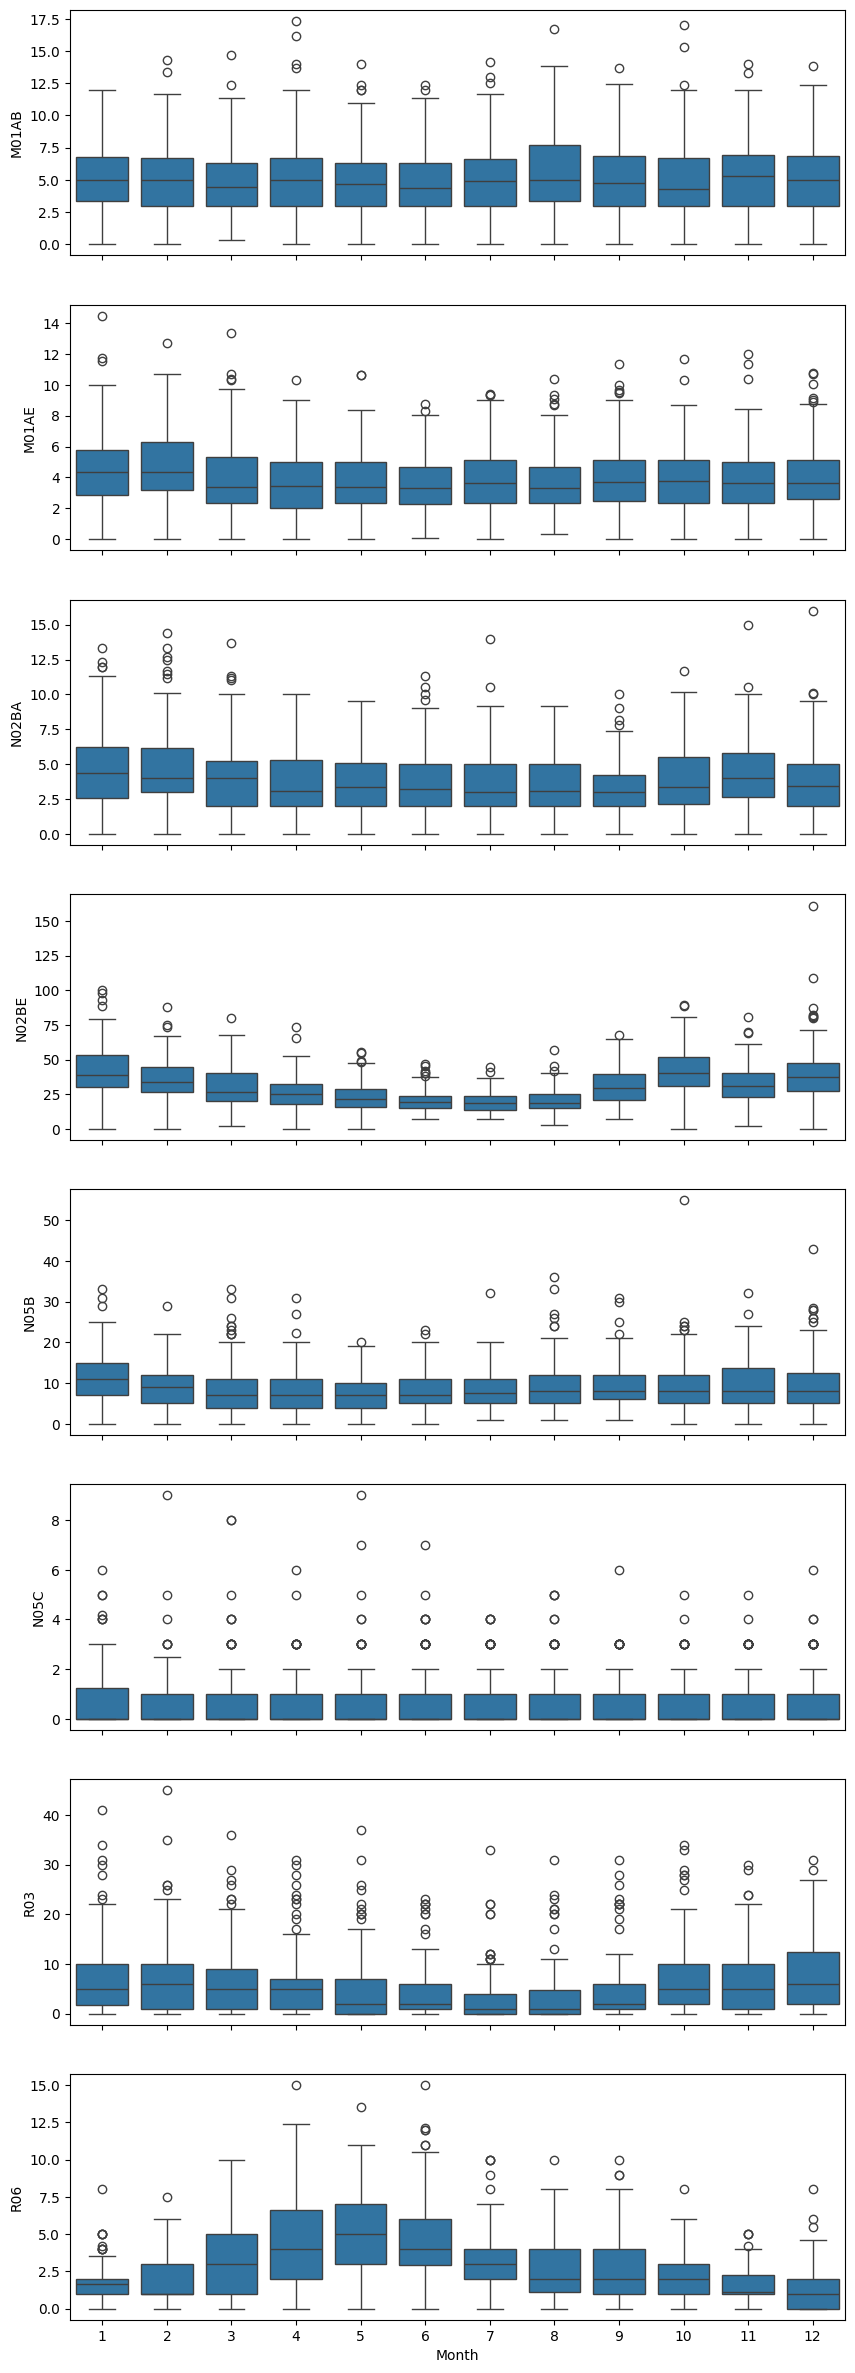

In [3]:
import seaborn as sns
dfatc_daily = pd.read_csv('/content/salesdaily.csv')
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='Month', y=name, ax=ax)

Below, boxplots on a weekly scale are shown, for the purpose of exploring the weakly seasonality. Some weekly seasonality is visible.

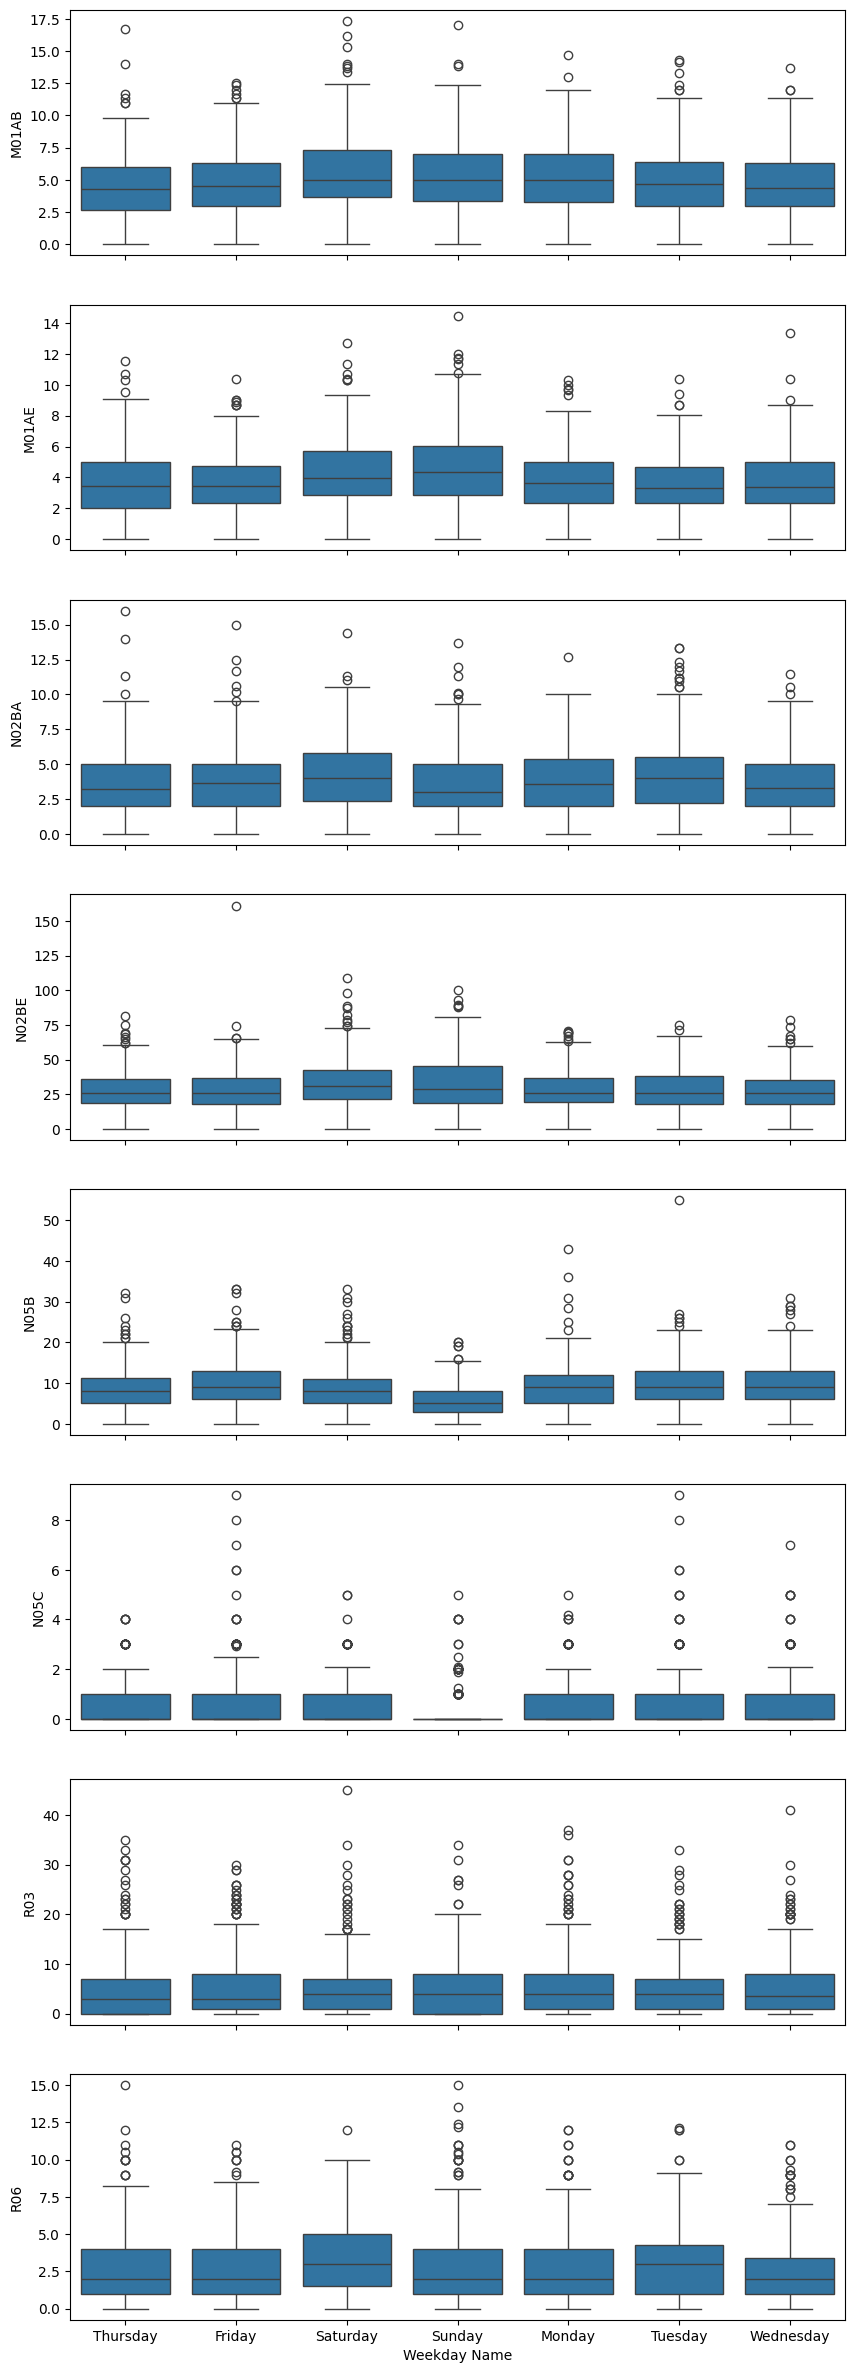

In [4]:
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='Weekday Name', y=name, ax=ax)

Another visualization that can be useful for discovering seasonality patterns is related to rolling window means. Analysis below shows 30-day and 365-day rolling mean and 30-day rolling standard deviation of sales data.

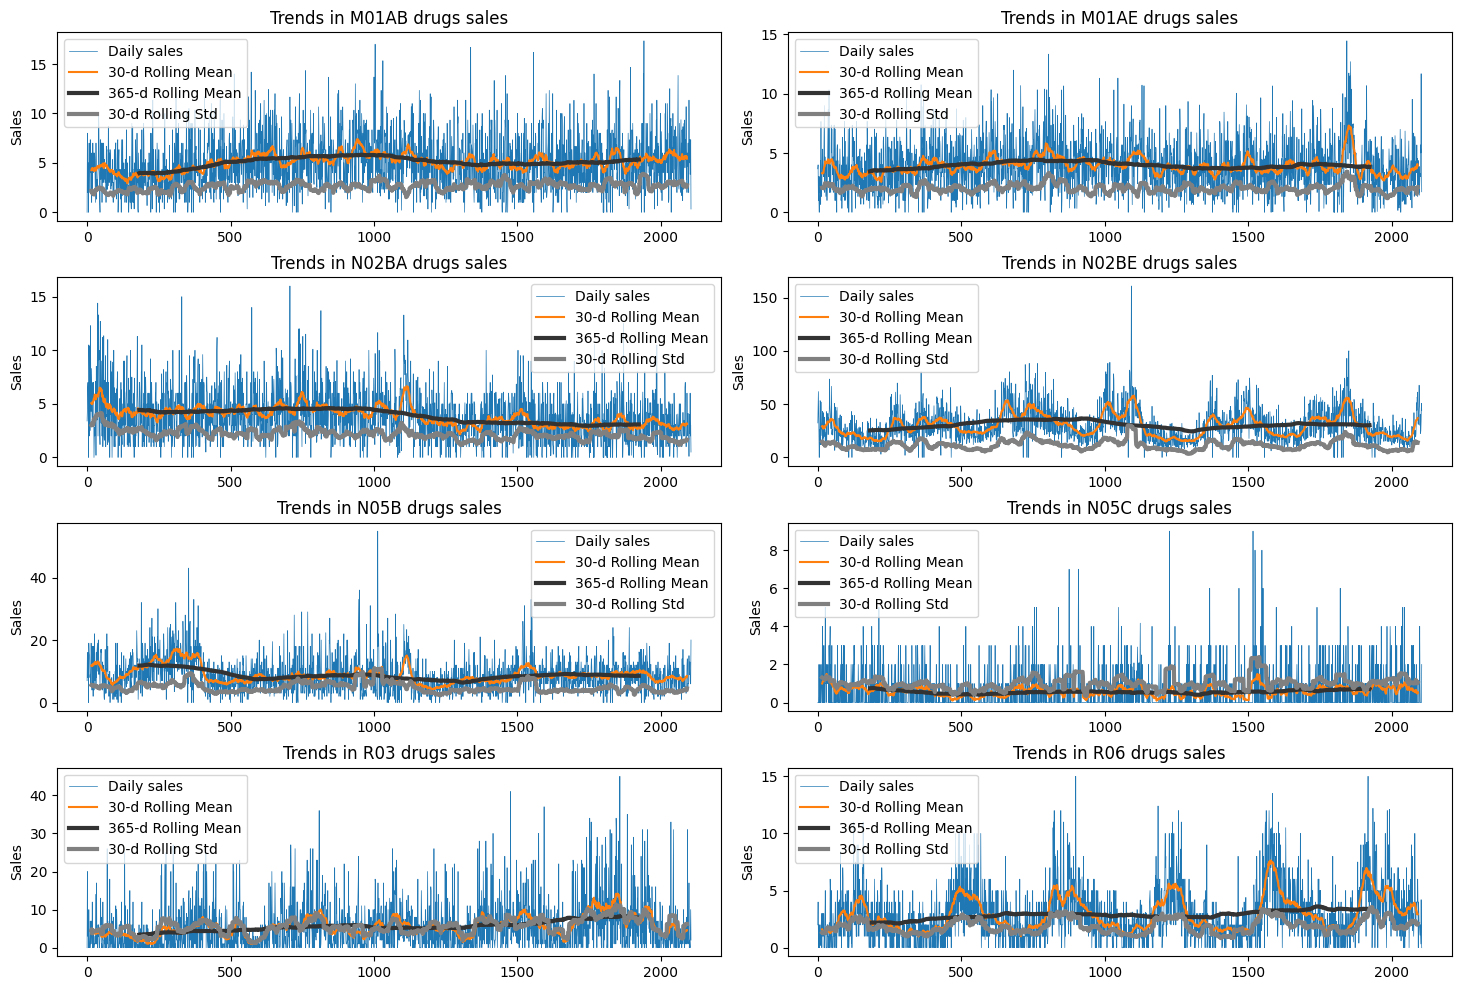

In [5]:
dfatc_daily=pd.read_csv('/content/salesdaily.csv')
cols_plot = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
dfatc_365d = dfatc_daily[cols_plot].rolling(window=365, center=True).mean()
dfatc_30d = dfatc_daily[cols_plot].rolling(30, center=True).mean()
dfatc_std = dfatc_daily[cols_plot].rolling(30, center=True).std()
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for x in cols_plot:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ax[rowindex,colindex].plot(dfatc_daily.loc[:,x], linewidth=0.5, label='Daily sales')
    ax[rowindex,colindex].plot(dfatc_30d.loc[:,x], label='30-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_365d.loc[:,x], color='0.2', linewidth=3, label='365-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_std.loc[:,x], color='0.5', linewidth=3, label='30-d Rolling Std')
    ax[rowindex,colindex].set_ylabel('Sales')
    ax[rowindex,colindex].legend()
    ax[rowindex,colindex].set_title('Trends in '+x+' drugs sales');
    subplotindex=subplotindex+1
plt.show()

Image below shows trends for each of the drug categories, represented by the 365-d rolling means for each of those categories.

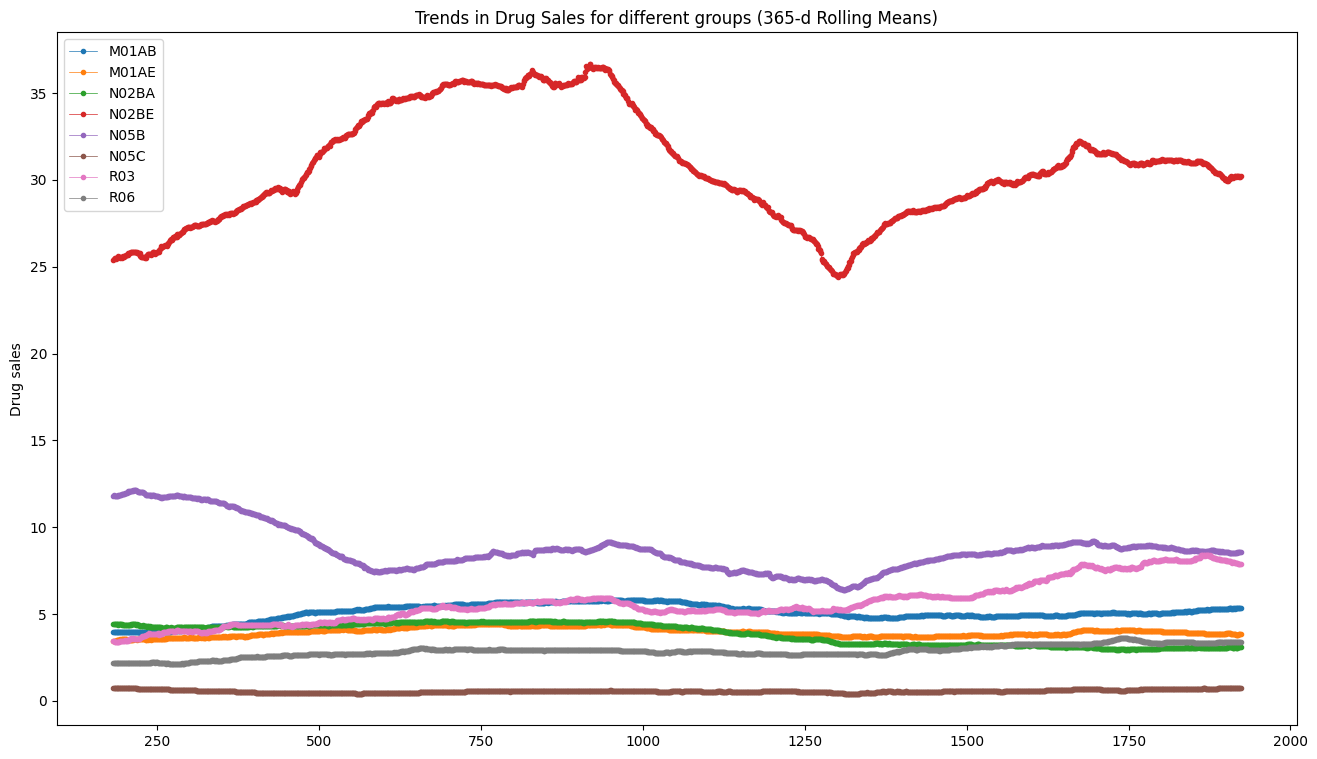

In [6]:
fig, ax = plt.subplots(figsize=(16,9))
for nm in cols_plot:
    ax.plot(dfatc_365d[nm], label=nm, marker='.', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.set_ylabel('Drug sales')
    ax.set_title('Trends in Drug Sales for different groups (365-d Rolling Means)');

Trends and seasonality can be explored in time series decomposition view, based on 30d rolling means.

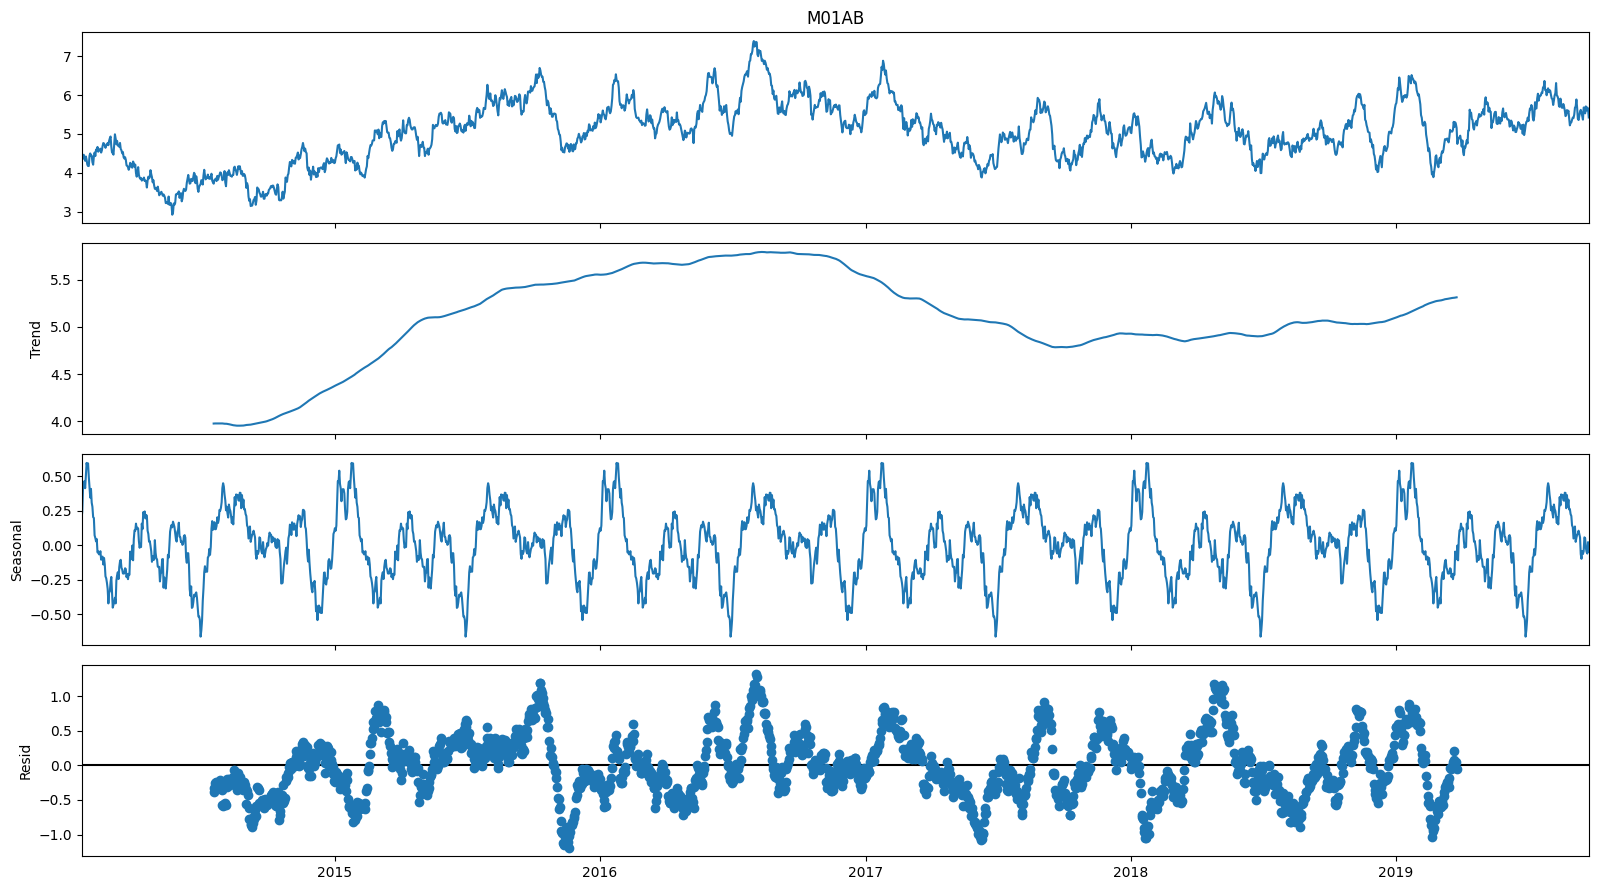

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming dfatc_daily['datum'] is your date column
dfatc_daily = dfatc_daily.set_index('datum')
# Ensure your index is a DatetimeIndex
dfatc_daily.index = pd.to_datetime(dfatc_daily.index)

# Replace freq with period
result = seasonal_decompose(dfatc_daily['M01AB'].rolling(30, center=True).mean().dropna(), period=365, model='additive')

plt.rcParams["figure.figsize"] = (16,9)
result.plot()
plt.show()

Function seasonal_decompose can be used for analysis of the portions of each component of time series. This is especially useful when determining uptake of residuals in data, based on the decomposed data. The volume of this uptake implies the predictability of the time series - higher the residuals, lower the predictability. To some extent, the proportion of the residuals when comparing with trend and seasonality can be also illustrated by the rolling means and standard deviation plots above.

In [11]:
df = pd.read_csv('/content/salesweekly.csv')
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    # Replace freq with period
    result = seasonal_decompose(df[x], period=52, model='additive')
    dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
    dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
    dfs=dfs.dropna()
    res=dfs['residuals'].values
    obs=dfs['observed'].values
    resmean=np.mean(np.abs(res))
    obsmean=np.mean(np.abs(obs))
    perc=resmean*100/obsmean
    print(x+' RESMEAN:'+str(resmean)+', OBSMEAN:'+str(obsmean)+', PERC:'+str(perc)+'%')

M01AB RESMEAN:5.26715996284115, OBSMEAN:35.59490833332001, PERC:14.797509558159527%
M01AE RESMEAN:4.319542609675869, OBSMEAN:28.00801458336, PERC:15.422523423856601%
N02BA RESMEAN:3.9228389592521657, OBSMEAN:27.083016, PERC:14.484498178682042%
N02BE RESMEAN:29.534357236963668, OBSMEAN:217.6597028336, PERC:13.569051529737028%
N05B RESMEAN:12.94840305932125, OBSMEAN:61.96614999972, PERC:20.895929566997072%
N05C RESMEAN:2.0384606385595405, OBSMEAN:3.871833333332, PERC:52.648460382081936%
R03 RESMEAN:11.722244335544508, OBSMEAN:40.06845833336, PERC:29.25554119906046%
R06 RESMEAN:4.278758416393868, OBSMEAN:19.744589999960002, PERC:21.67053565762842%


### 4.2.2. Stationarity analysis

Stationarity of time-series is the property of exhibiting constant statistical properties over time (for example, mean, variance, autocorrelation). It can be visually determined by plotting rolling statistics (rolling means and variances). In stationary time series, the mean of the series, variance of the series and covariance of the i th term and the (i + m) th term should not be a function of time.

We can use Augmented Dickey-Fuller (ADF) test to check stationarity of the data. Possible values of regression parameters of ADF are:
- c : constant only (default)
- ct : constant and trend
- ctt : constant, and linear and quadratic trend
- nc : no constant, no trend

In [12]:
df = pd.read_csv('/content/salesweekly.csv')
from statsmodels.tsa.stattools import adfuller

for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    dftest = adfuller(df[x], regression='ct', autolag='AIC')
    print("ADF test for "+x)
    print("-----------------------------")
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

ADF test for M01AB
-----------------------------
Test statistic = -3.700
P-value = 0.022
Critical values :
	1%: -3.9897903649837616 - The data is not stationary with 99% confidence
	5%: -3.425478311521626 - The data is  stationary with 95% confidence
	10%: -3.1358607194990724 - The data is  stationary with 90% confidence
ADF test for M01AE
-----------------------------
Test statistic = -8.717
P-value = 0.000
Critical values :
	1%: -3.98926783537037 - The data is  stationary with 99% confidence
	5%: -3.425226747185185 - The data is  stationary with 95% confidence
	10%: -3.1357131066666666 - The data is  stationary with 90% confidence
ADF test for N02BA
-----------------------------
Test statistic = -2.670
P-value = 0.249
Critical values :
	1%: -3.990441532957606 - The data is not stationary with 99% confidence
	5%: -3.425791763669738 - The data is not stationary with 95% confidence
	10%: -3.1360446341572343 - The data is not stationary with 90% confidence
ADF test for N02BE
------------

Augmented Dickey-Fuller (ADF) test have shown that all data, but N02BA (P-value=0.249) in the series were stationary, with maximum confidence.

In [14]:
import warnings
from statsmodels.tsa.stattools import kpss
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")
df = pd.read_csv('/content/salesweekly.csv')
for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    print(" > Is "+x+" data stationary ?")
    # Apply log transformation after replacing 0 with a small value
    # Replace 0 with a small value to avoid log(0) errors
    data = df[x].replace(0, 1e-9)
    dftest = kpss(np.log(data), 'ct')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[3].items():
        print("\t{}: {}".format(k, v))

 > Is M01AB data stationary ?
Test statistic = 0.469
P-value = 0.010
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is M01AE data stationary ?
Test statistic = 0.347
P-value = 0.010
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N02BA data stationary ?
Test statistic = 0.233
P-value = 0.010
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N02BE data stationary ?
Test statistic = 0.095
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N05B data stationary ?
Test statistic = 0.197
P-value = 0.017
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N05C data stationary ?
Test statistic = 0.249
P-value = 0.010
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is R03 data stationary ?
Test statistic = 0.055
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is R06 data stationary ?
Test statistic = 0.032
P-value = 0.100

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test found the trend non-stationarity in N02BE, R03 and R06.

### 4.2.3. Regularity analysis

For calculating regularity and predictability of time series, Approximate Entropy test was used. For all series, entropy values were higher than 1 indicating low predictability, with highest values for M01AE, M01AB and N02BA.

In [15]:
df = pd.read_csv('/content/salesweekly.csv')
def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(U)
    return abs(_phi(m+1) - _phi(m))

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    print(x + ': ' + str(ApEn(df[x].values, m=2, r=0.2*np.std(df[x].values))))

M01AB: 1.141130089570642
M01AE: 1.166363924596575
N02BA: 1.1370638730125302
N02BE: 1.058024809082593
N05B: 1.074437415034502
N05C: 1.0361887401424648
R03: 1.1847216239035152
R06: 1.031759595747876


### 4.2.4. Autocorrelation analysis

Autocorrelation analysis illustrates the potential for time series data prediction. Autocorrelation plots graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. Pearson coefficient is used to measure autocorrelation. Thus, the following analysis is relevant only for data with normal Gaussian distribution.

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function (ACF). This plot is sometimes called a correlogram or an autocorrelation plot. Plot shows the lag value along the x-axis and the correlation on the y-axis between -1 and 1. Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation.

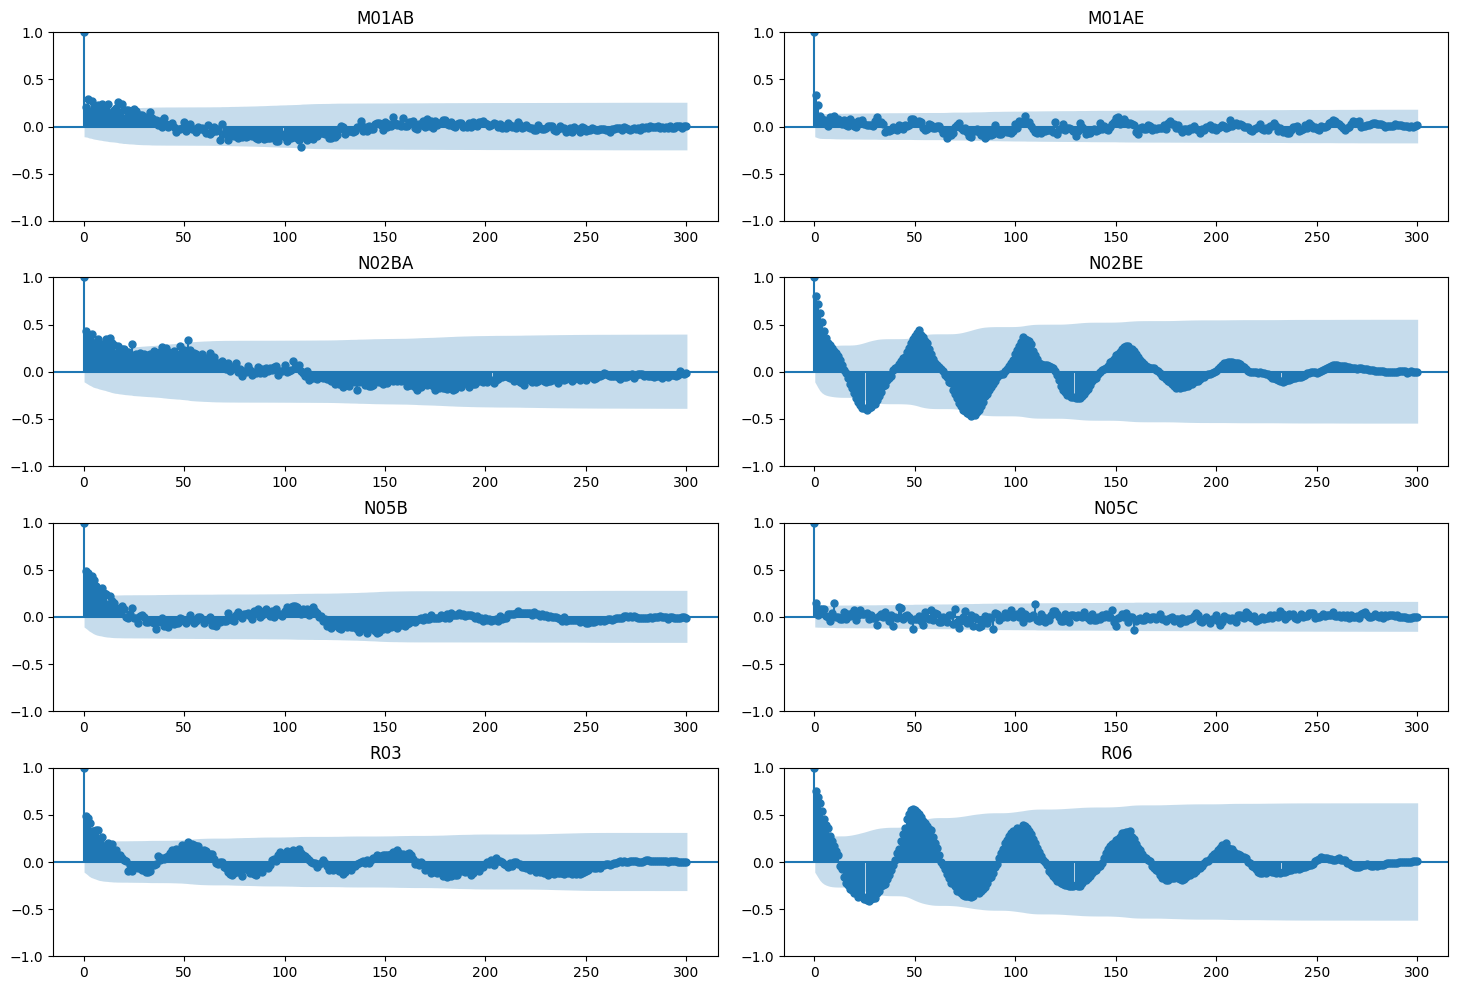

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
df = pd.read_csv('/content/salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(18,12))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_acf(df[x], lags=300, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1


In general, the "partial" correlation between two variables is the amount of correlation between them which is not explained by their mutual correlations with a specified set of other variables. For example, if we are regressing a variable Y on other variables X1, X2, and X3, the partial correlation between Y and X3 is the amount of correlation between Y and X3 that is not explained by their common correlations with X1 and X2.

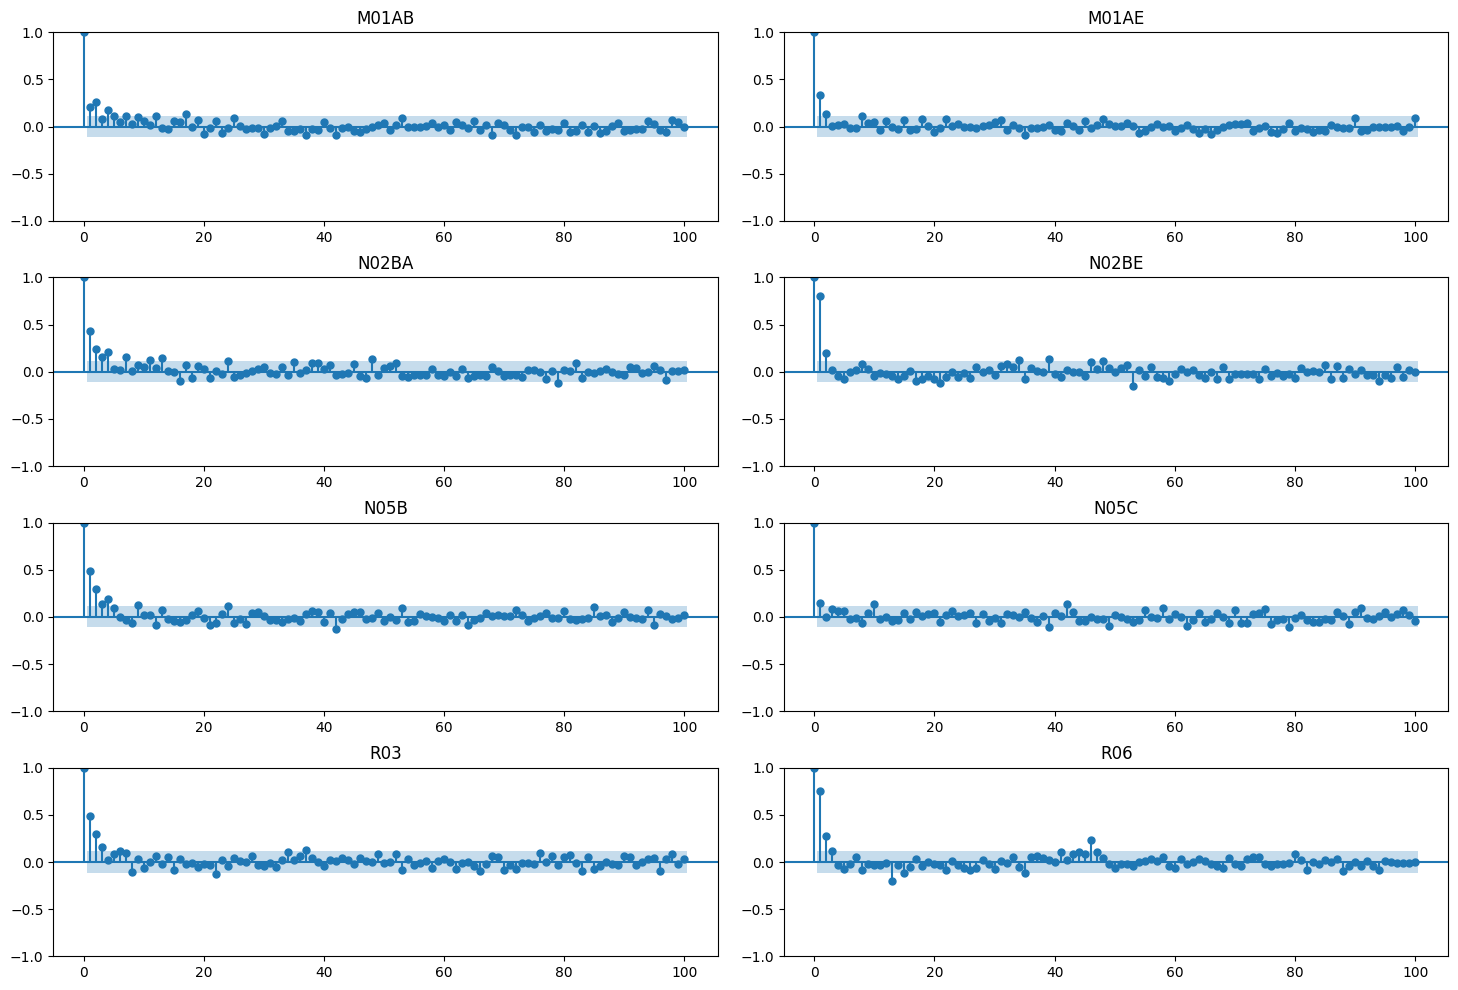

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
df = pd.read_csv('/content/salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_pacf(df[x], lags=100, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

Minor autocorrelation is observed at ACF (Auto-Correlation Function) and PACF (Partial Auto-Correlation Function) plots for all series, with exception of N05C sales. N02BE, R03 and R06 series were found to exhibit annual seasonality.

### 4.2.5. Data distribution analysis

Chart with daily sales for different categories of interest is shown below. N02BE and N05B charts, though showing the similar trends, are suppresed because of the larger scale which makes the other illustrations less readable.

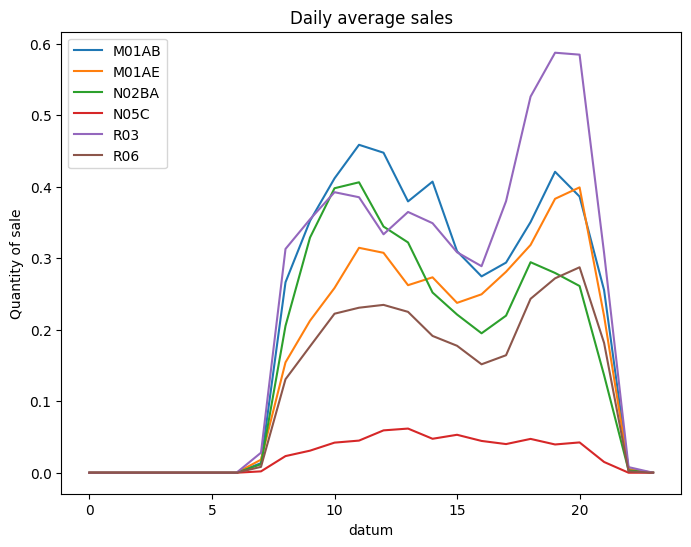

In [20]:
df = pd.read_csv('/content/saleshourly.csv')
df['datum']= pd.to_datetime(df['datum'])

grp1=df.groupby(df.datum.dt.hour)['M01AB'].mean()
grp2=df.groupby(df.datum.dt.hour)['M01AE'].mean()
grp3=df.groupby(df.datum.dt.hour)['N02BA'].mean()
grp6=df.groupby(df.datum.dt.hour)['N05C'].mean()
grp7=df.groupby(df.datum.dt.hour)['R03'].mean()
grp8=df.groupby(df.datum.dt.hour)['R06'].mean()

plt.title('Daily average sales')
plt.xlabel('Time of day')
plt.ylabel('Quantity of sale')

grp1.plot(figsize=(8,6))
grp2.plot(figsize=(8,6))
grp3.plot(figsize=(8,6))
grp6.plot(figsize=(8,6))
grp7.plot(figsize=(8,6))
grp8.plot(figsize=(8,6))

plt.legend(['M01AB', 'M01AE', 'N02BA', 'N05C', 'R03', 'R06'], loc='upper left')

plt.show()

## 4.3. Time series forecasting

Forecasting models were fitted with weekly time-series data with dataset of 302 rows. Three forecasting methods were tested: ARIMA, Prophet and LSTM. Train-test split method was used (52 weeks of test data). MSE was used as metrics for comparing the performance and also as a loss function for LSTM. Mean Absolute Percentage Error (MAPE) is also measured for each of the scenarios. In order to define the baseline forecasting accuracy to improve from, three tests were performed. Average method was used as a baseline for long-term forecasting, while Naïve and Seasonal Naïve were used for rolling forecasts.

Forecasting results are validated by using two approaches: short-term and long-term forecasts. For short-term forecasts (or so-called rolling-forecast) validation or walk-forward model validation, train-test split validation is performed in iterative fashion, where observations are added to the training dataset after every individual weekly sales prediction, while the model is fitted in each iteration. Therefore, during testing, prediction in a timestep t is based on the model which fits the training set consisting of observations in timesteps (0,t-1), or: f(t) = f(o[0:t-1]). Long-term forecasts validation is based on MSE of one-year forecast, compared to actual observations.

All MSE metrics will be stored in a dataframe, which will be later use for presentation of the overall results and comparison. Rolling forecasting will be carried out by using 5 methods (Naive, Seasonal Naive, ARIMA, AutoARIMA, Prophet). Longterm forecasting will be carried out by using 7 methods (Average, ARIMA, AutoARIMA, Prophet, Vanilla LSTM, Stacked LSTM, Bidirectional LSTM).

In [21]:
resultsRolling={'M01AB':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'M01AE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BA':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05B':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05C':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R03':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R06':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsRollingdf = pd.DataFrame(resultsRolling)
resultsRollingdf.index = ['Naive MSE', 'Naive MAPE', 'Seasonal Naive MSE', 'Seasonal Naive MAPE',
                          'ARIMA MSE', 'ARIMA MAPE', 'AutoARIMA MSE', 'AutoARIMA MAPE',
                         'Prophet MSE', 'Prophet MAPE']
resultsLongterm={'M01AB':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'M01AE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BA':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05B':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05C':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R03':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R06':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsLongtermdf = pd.DataFrame(resultsLongterm)
resultsLongtermdf.index = ['Average MSE', 'Average MAPE', 'ARIMA MSE', 'ARIMA MAPE',
                           'AutoARIMA MSE', 'AutoARIMA MAPE', 'Prophet MSE', 'Prophet MAPE',
                          'Vanilla LSTM MSE', 'Vanilla LSTM MAPE', 'Stacked LSTM MSE', 'Stacked LSTM MAPE',
                          'Bidirectional LSTM MSE', 'Bidirectional LSTM MAPE']

### 4.3.1. Baseline forecasting accuracy

In this subsection, three summaries of the reference benchmarks, namely Naïve methods are provided. First, Naïve forecasting was done and results presented. Second, average method was used to forecast. Finally, seasonal Naïve forecast was carried out for the series that has been found as seasonal: N02BE, R03 and R06. See Theoretical background section for explanation of those methods.

#### 4.3.1.1. Naïve forecasting

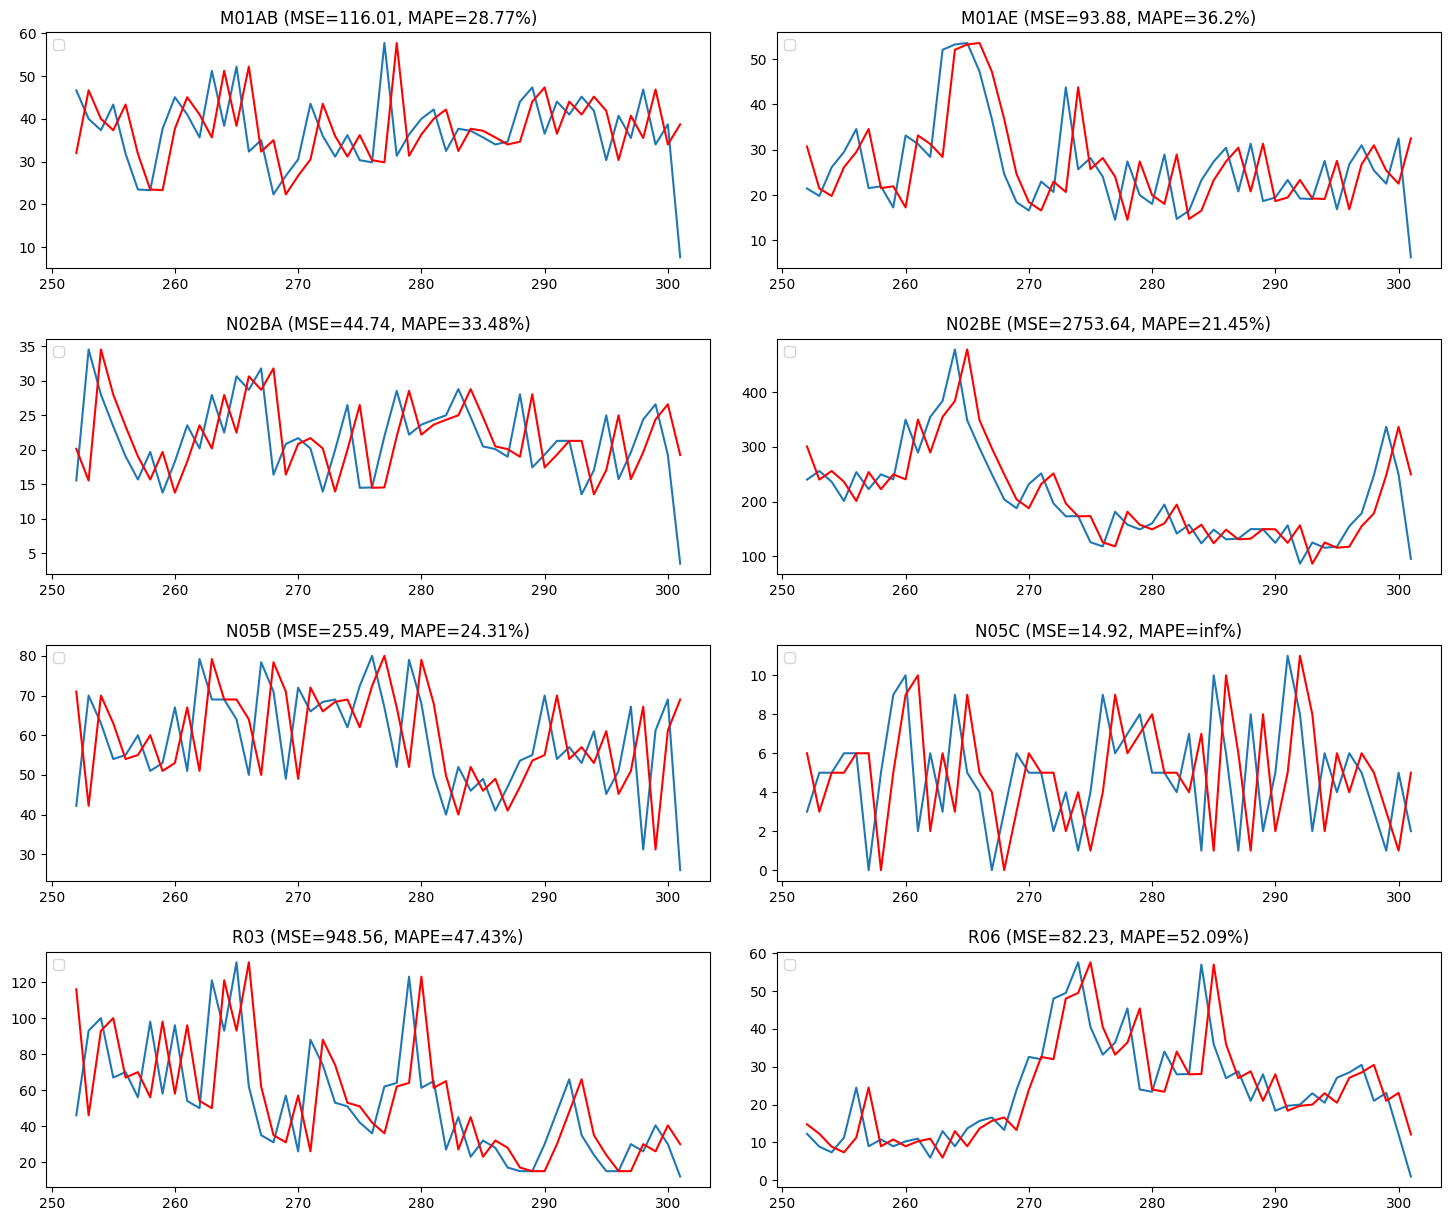

In [22]:
df = pd.read_csv('/content/salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ds=df[x]
    dataframe = concat([ds.shift(1), ds], axis=1)
    dataframe.columns = ['t+1', 't-1']
    size = len(dataframe)-50
    X=dataframe['t-1']
    Y=dataframe['t+1']
    test, predictions = X[size:len(X)], Y[size:len(Y)]
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Naive MSE',x]=error
    resultsRollingdf.loc['Naive MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### 4.3.1.2. Average method forecasting

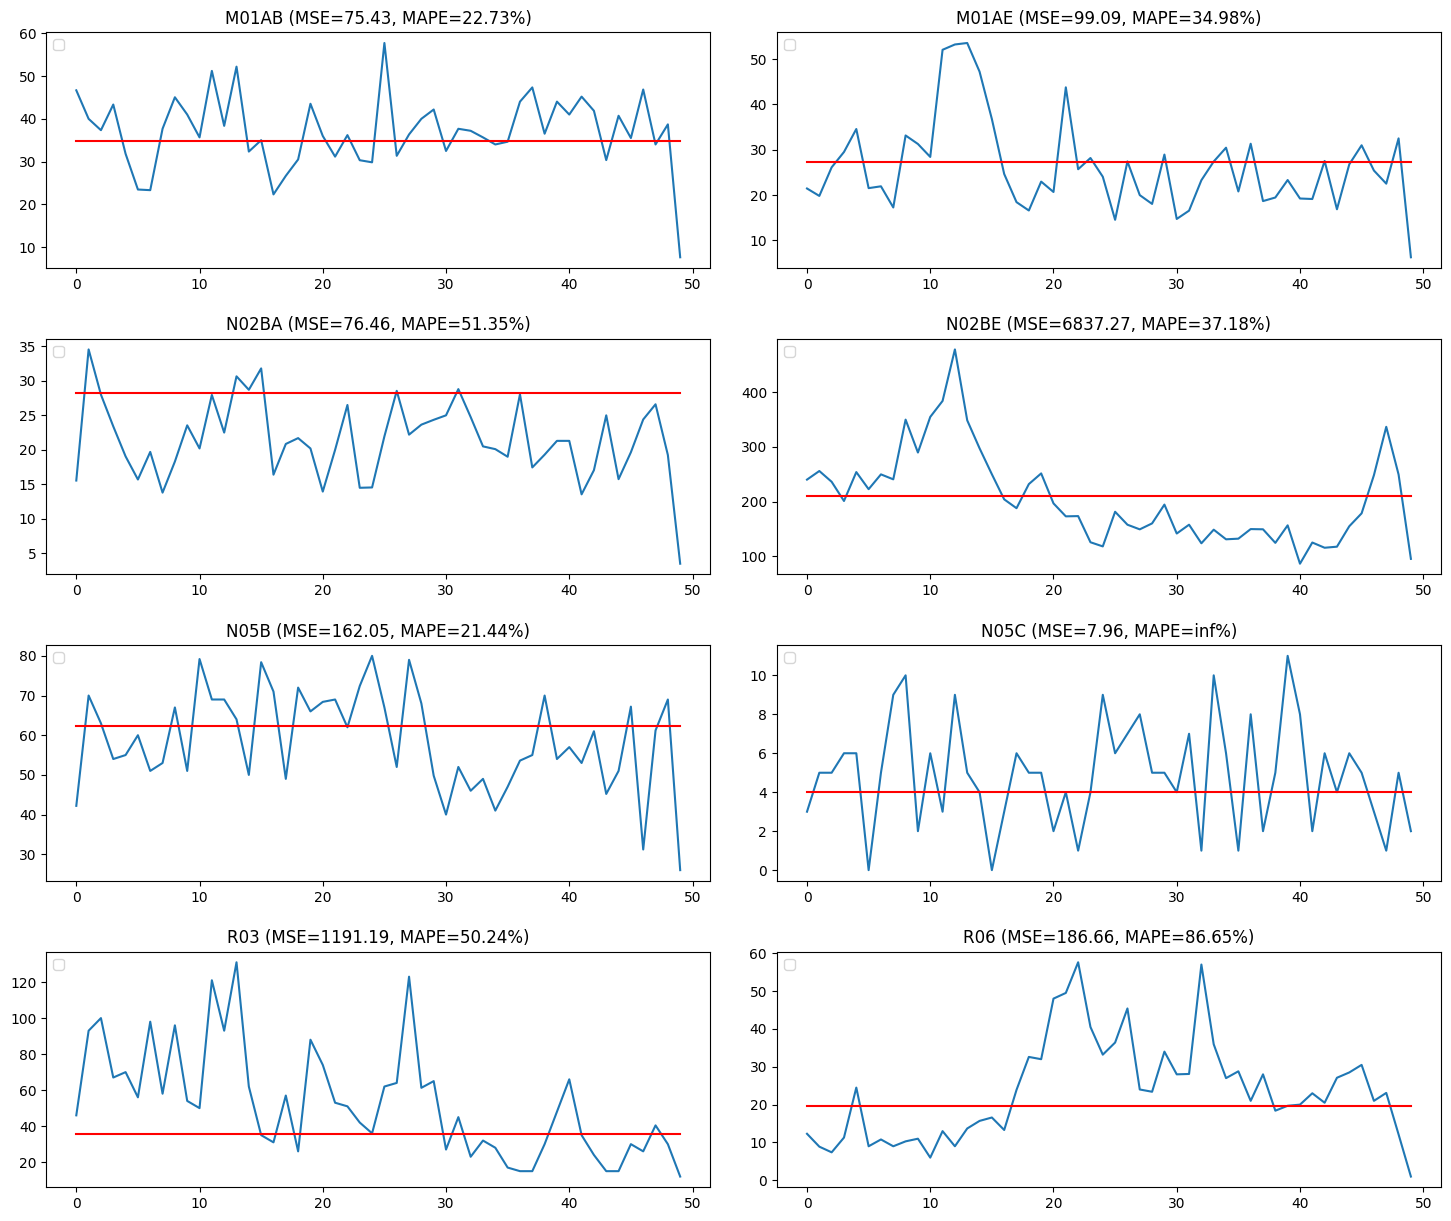

In [23]:
df = pd.read_csv('/content/salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-50
    test = X[size:len(X)]
    mean = np.mean(X[0:size])
    predictions = np.full(50,mean)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsLongtermdf.loc['Average MSE',x]=error
    resultsLongtermdf.loc['Average MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### 4.3.1.3. Seasonal Naïve forecasting

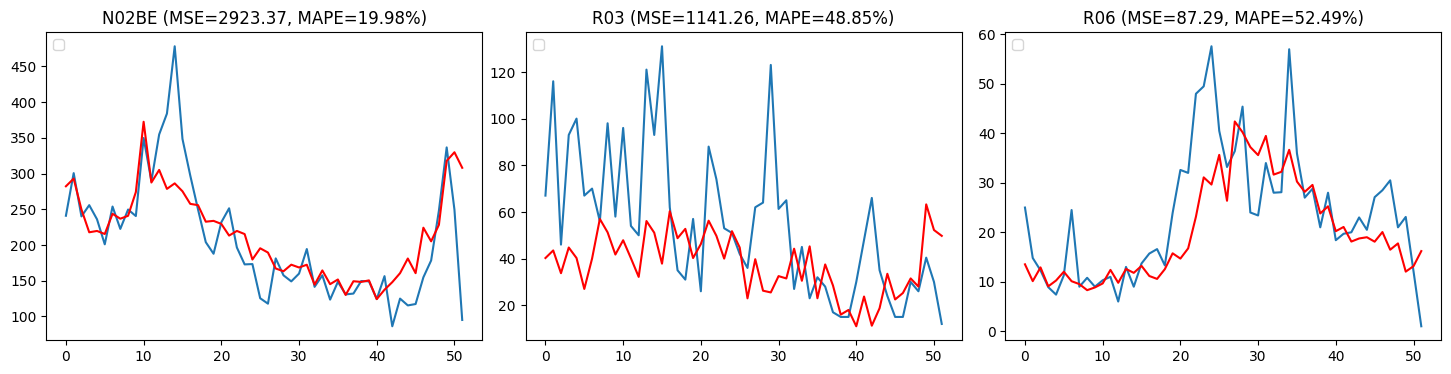

In [24]:
df = pd.read_csv('/content/salesweekly.csv')
subplotindex=0
numrows=1
numcols=3
fig, ax = plt.subplots(numrows, numcols, figsize=(18,4))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['N02BE','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-52
    test = X[size:len(X)]
    train = X[0:size]
    predictions=list()
    history = [x for x in train]
    for i in range(len(test)):
        obs=list()
        for y in range(1,5):
            obs.append(train[-(y*52)+i])
        yhat = np.mean(obs)
        predictions.append(yhat)
        history.append(test[i])
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Seasonal Naive MSE',x]=error
    resultsRollingdf.loc['Seasonal Naive MAPE',x]=perror
    ax[colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[colindex].plot(test)
    ax[colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

### 4.3.2. ARIMA Forecasting

ARIMA method was used to to carry out short-term (rolling forecast) and long-term forecasting based on test data. Before each forecast is made, the process of optimizing hyper-parameters (p,d,q) of ARIMA model was carry out. Then, with optimal set of parameters, rolling forecast and long-term forecasting was carried out.
Seasonal ARIMA (SARIMA) method was tested by using Auto-ARIMA implementation. This implementation has built-in stepwise optimizer which chooses optimal set of parameters (p,d,q for non-seasonal and p,d,q,P,D,Q for seasonal series, namely N02BE, R03 and R06).

#### 4.3.2.1. Choosing parameters for ARIMA model

First, method arma_order_select_ic was used to determine initial p and q parameters. The method computes Akaike’s Information Criterion (AIC) for many ARIMA models and chooses the best configuration. It is important to note that AIC tend not to be a good guide to selecting the appropriate order of differencing (d) of a model, but only for selecting the values of p and q.

In [25]:
import statsmodels.api as sm
df = pd.read_csv('/content/salesweekly.csv')
warnings.filterwarnings("ignore")
for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    resDiff = sm.tsa.arma_order_select_ic(df[x], max_ar=5, max_ma=5, ic='aic', trend='c')
    print('ARMA(p,q,'+x+') =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q,M01AB) = (3, 3) is the best.
ARMA(p,q,M01AE) = (2, 0) is the best.
ARMA(p,q,N02BA) = (3, 3) is the best.
ARMA(p,q,N02BE) = (2, 2) is the best.
ARMA(p,q,N05B) = (4, 3) is the best.
ARMA(p,q,N05C) = (3, 2) is the best.
ARMA(p,q,R03) = (1, 1) is the best.
ARMA(p,q,R06) = (2, 2) is the best.


However, AIC is not used to score accuracy of the forecasting methods in this research. Mean squared error is used instead. For that, reason, grid search optimization method was applied, where different combinations of the hyper-parameters were used to calculate MSE and then, the combination producing the least MSE was chosen as optimal. Grid search optimization is carried out for both approaches in forecasting: rolling and long-term.

Grid search optimization for rolling forecast produced the following best combinations of the hyper-parameters:

In [26]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(f, dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print(f+' - Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

warnings.filterwarnings("ignore")

df = pd.read_csv('/content/salesweekly.csv')

for f in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    evaluate_models(f, df[f].values, p_values, d_values, q_values)

M01AB - Best ARIMANone MSE=inf
M01AE - Best ARIMANone MSE=inf
N02BA - Best ARIMANone MSE=inf
N02BE - Best ARIMANone MSE=inf
N05B - Best ARIMANone MSE=inf
N05C - Best ARIMANone MSE=inf
R03 - Best ARIMANone MSE=inf
R06 - Best ARIMANone MSE=inf


Grid search optimization for long-term forecast produced the following best combinations of the hyper-parameters:

In [27]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) - 50)
    train, test = X[0:train_size], X[train_size:]
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    forecast = model_fit.predict(1,len(test))
    error = mean_squared_error(test, forecast)
    return error

def evaluate_models(f, dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print(f+' - Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

warnings.filterwarnings("ignore")

for f in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    evaluate_models(f, df[f].values, p_values, d_values, q_values)

M01AB - Best ARIMANone MSE=inf
M01AE - Best ARIMANone MSE=inf
N02BA - Best ARIMANone MSE=inf
N02BE - Best ARIMANone MSE=inf
N05B - Best ARIMANone MSE=inf
N05C - Best ARIMANone MSE=inf
R03 - Best ARIMANone MSE=inf
R06 - Best ARIMANone MSE=inf


From the optimization stand of point, some series are considered as so-called white noise - random time series data. Those are series for whom the best result was achieved with p=0, d=0 and q=0.

#### 4.3.2.2. Rolling forecasting with ARIMA model

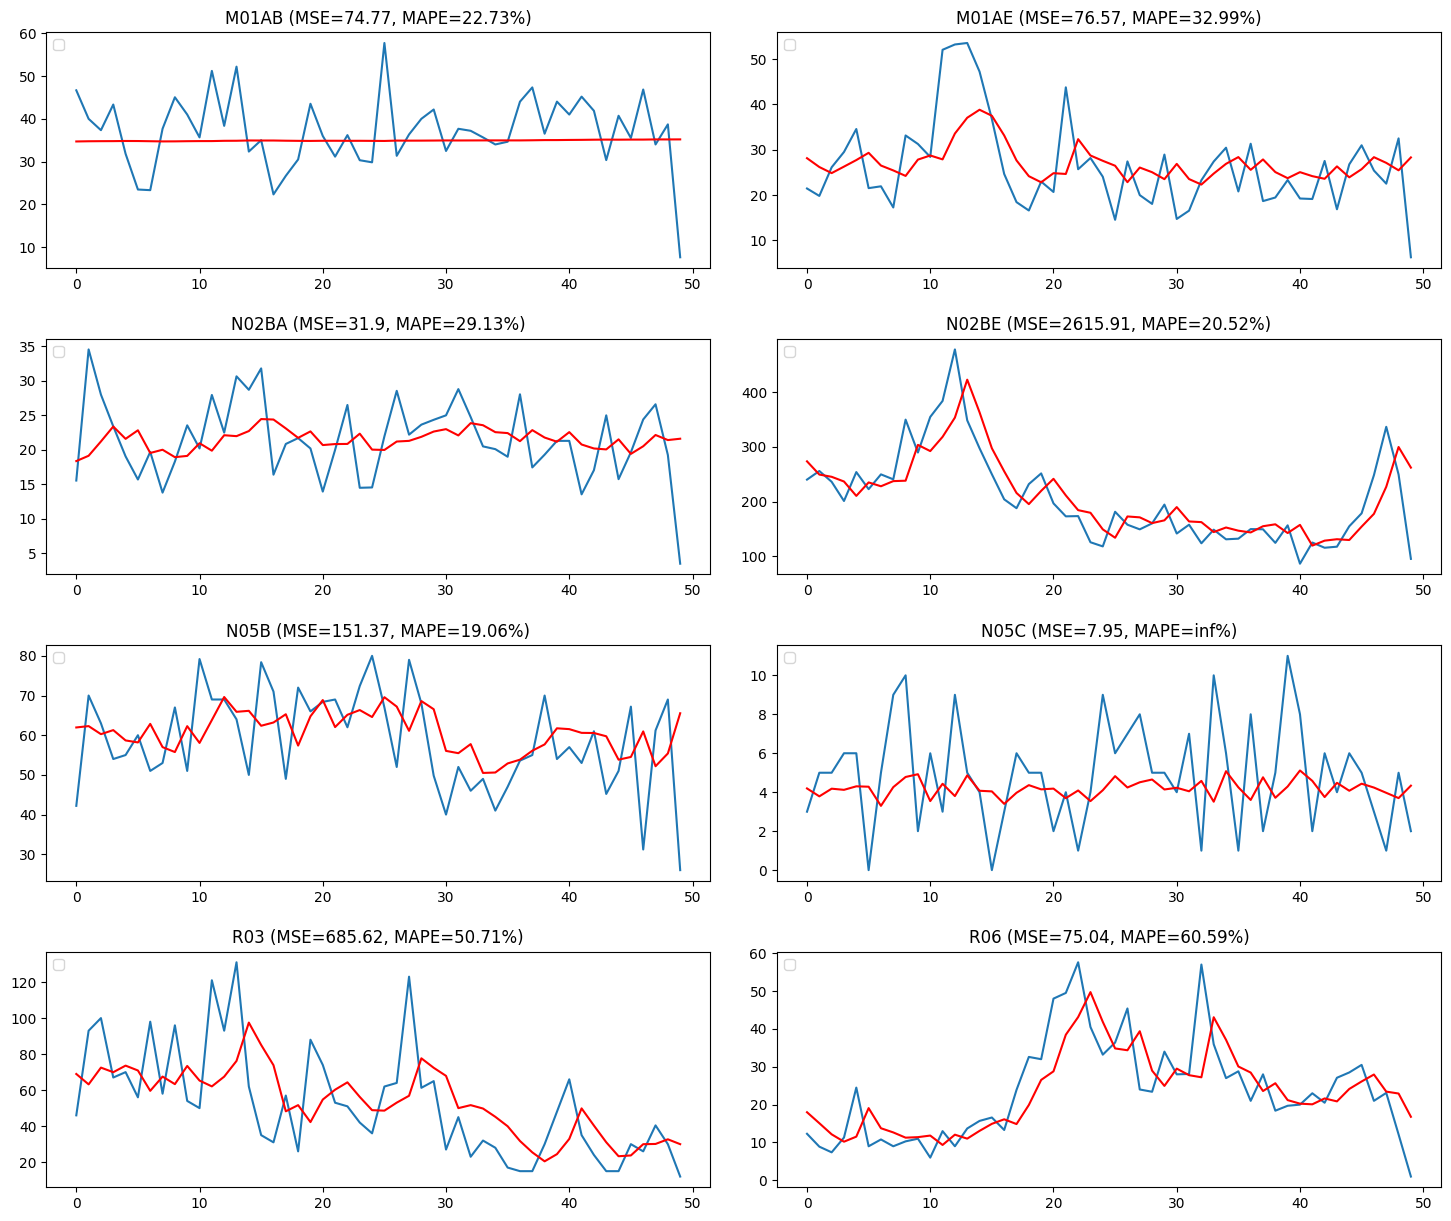

In [56]:
from statsmodels.tsa.arima.model import ARIMA # Import the new ARIMA class
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from IPython.display import display

df = pd.read_csv('/content/salesweekly.csv')

M01AB= {'series':'M01AB','p':0,'d':0,'q':0}
M01AE= {'series':'M01AE','p':2,'d':0,'q':0}
N02BA= {'series':'N02BA','p':5,'d':1,'q':1}
N02BE= {'series':'N02BE','p':2,'d':0,'q':0}
N05B= {'series':'N05B','p':0,'d':0,'q':5}
N05C= {'series':'N05C','p':0,'d':0,'q':1}
R03= {'series':'R03','p':5,'d':1,'q':1}
R06= {'series':'R06','p':1,'d':0,'q':1}

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in [M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x['series']].values
    size = len(X)-50
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        # Use the new ARIMA class for model creation
        model = ARIMA(history, order=(x['p'],x['d'],x['q']))
        # Remove the disp argument from the fit method
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['ARIMA MSE',x['series']]=error
    resultsRollingdf.loc['ARIMA MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### 4.3.2.3. Long-term forecasting with ARIMA model

In [30]:
from statsmodels.tsa.arima.model import ARIMA # Import the new ARIMA class
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from IPython.display import display

# ... (rest of your code remains the same) ...


for x in [M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x['series']].values
    size = len(X)-50
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        # Use the new ARIMA class for model creation
        model = ARIMA(history, order=(x['p'],x['d'],x['q']))
        # Remove the disp argument from the fit method
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['ARIMA MSE',x['series']]=error
    resultsRollingdf.loc['ARIMA MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### 4.3.2.4. Rolling forecasting with Auto-ARIMA model

In [32]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.3 MB/s eta 0:00:00


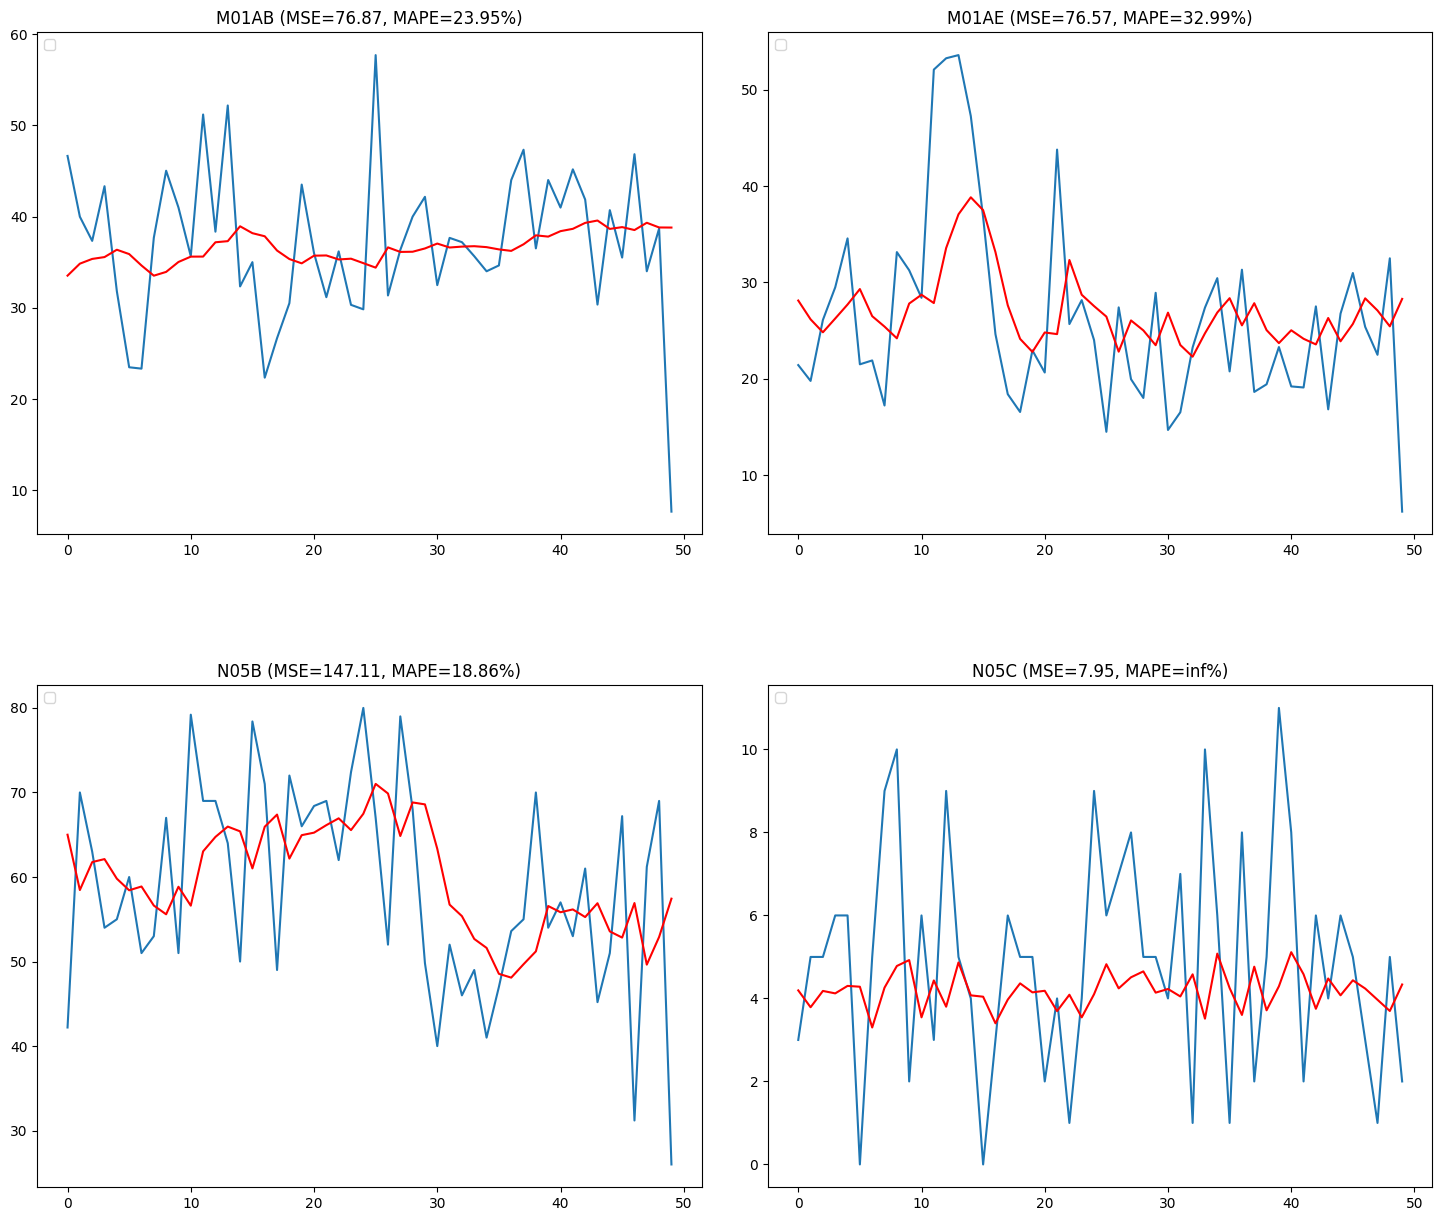

In [35]:
from pmdarima.arima import auto_arima # Changed import statement

df = pd.read_csv('/content/salesweekly.csv')
subplotindex=0
numrows=2
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in ['M01AB','M01AE','N05B','N05C']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x].values
    size = len(X)-50
    train, test = X[0:size], X[size:len(X)]
    history = [c for c in train]
    predictions = list()
    for t in range(len(test)):
        if (x=='N02BA' or x=='N02BE' or x=='R03' or x=='R06'):
            model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=52, max_d=1, max_D=1,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, seasonal=True,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
        else:
            model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, max_d=1,
                           trace=False, seasonal=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
        model_fit = model.fit(history)
        output = model_fit.predict(n_periods=1)
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['AutoARIMA MSE',x]=error
    resultsRollingdf.loc['AutoARIMA MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### 4.3.2.5. Long-term forecasting with Auto-ARIMA model

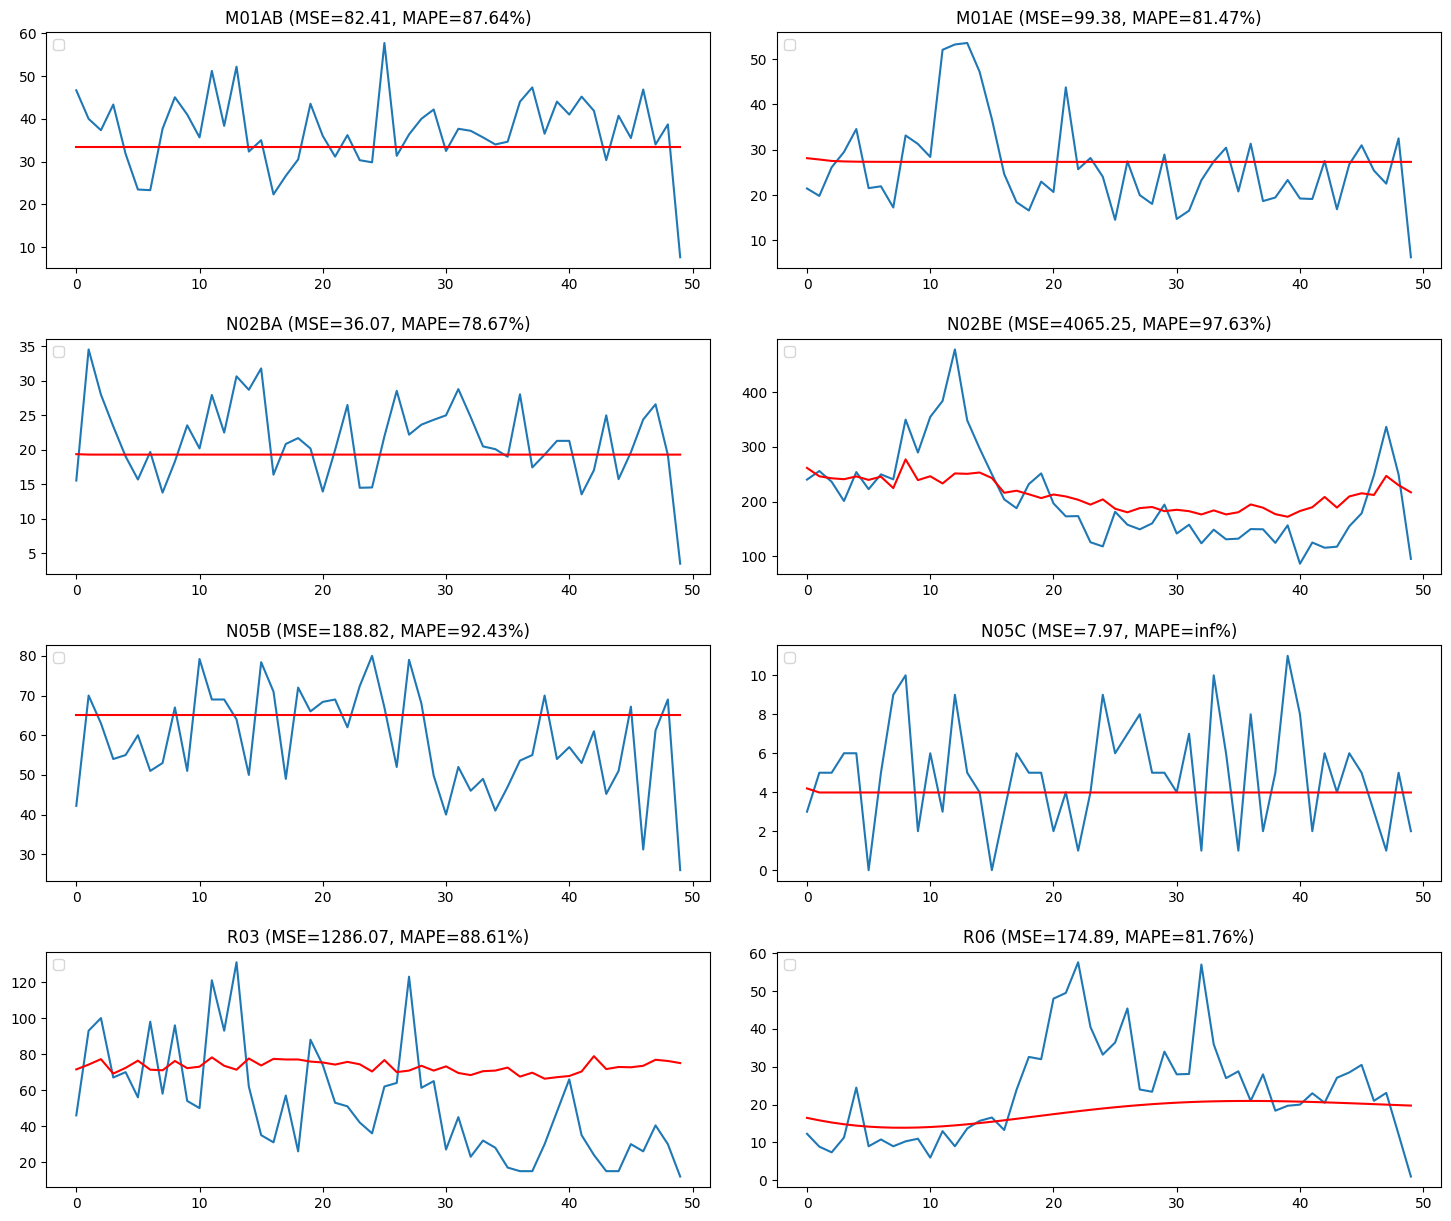

In [37]:
from pmdarima.arima import auto_arima

df = pd.read_csv('/content/salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x].values
    size = int(len(X) - 50)
    train, test = X[0:size], X[size:len(X)]
    if (x=='N02BE' or x=='R03' or x=='R06'):
        model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=52, max_d=1, max_D=1,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, seasonal=True,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
    else:
        model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, max_d=1,
                           trace=False, seasonal=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
    model_fit = model.fit(train)
    forecast = model_fit.predict(n_periods=len(test))
    error = mean_squared_error(test, forecast)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsLongtermdf.loc['AutoARIMA MSE',x]=error
    resultsLongtermdf.loc['AutoARIMA MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(forecast, color='red')
    subplotindex=subplotindex+1
plt.show()

### 4.3.3. Prophet forecasting

Prophet model is fited with data in two columns, where first one contains time information and is labeled as ds. Another stores actual time series data and is labeled as y.

Prophet model is tuned by using the following hyper-parameters:

- growth. For a linear trending, value should be 'linear'. If not, 'logistic'. In latter case, the cap (maximum value data will reach) and floor (minimum value data will reach) of your predictions need to be provided. This is typically determined by domain experts.
- interval_width. the uncertainty interval to produce a confidence interval around the forecast.
- fourier_order. the number of Fourier components each seasonality is composed of.
- n_changepoints. The changepoints parameter is used when the changepoint dates are supplied instead of having Prophet determine them. In practice Prophet should be let to do that alone.
- changepoint_range usually does not have that much of an effect on the performance.
- changepoint_prior_scale, is there to indicate how flexible the changepoints are allowed to be. In other words, how much can the changepoints fit to the data. If high it will be more flexible, but then overfitting is possible.
- seasonality_prior_scale parameter. This parameter will again allow your seasonalities to be more flexible.

<blockquote>While Prophet model is used both for rolling forecasts and long-term forecasting, optimization of hyper-parameters is carried out only for long-term forecasts. Optimal sets of hyper-parameters are then used also for rolling forecasts.</blockquote>

In [39]:
!pip install prophet
import prophet #Changed the library name

#### 4.3.3.1. Grid-search optimization of Prophet hyper-parameters

Before actual forecasting, the optimal set of hyper-parameters is determined by using grid-search method. NOTE: this is illustrative example; actual optimization is carried out with larger intervals of hyper-parameters' values.

In [41]:
df = pd.read_csv('/content/salesweekly.csv')

M01AB= {
    'series':'M01AB',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[10,30,50],
               'interval_width':[0.0005]
              }
}
M01AE= {
    'series':'M01AE',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],
               'interval_width':[0.0005]
              }
}
N02BA= {
    'series':'N02BA',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.005,0.01,0.05,0.1],
                   'interval_width':[0.0005]
              }
}
N02BE= {
    'series':'N02BE',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[5,10,50],'seasonality_prior_scale':[150,170,200],
               'interval_width':[0.0005]
              }
}
N05B= {
    'series':'N05B',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[1,5,10],
               'interval_width':[0.0005]
              }
}
N05C= {
    'series':'N05C',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.05,0.08,0.1,0.5],
               'interval_width':[0.0005]
              }
}
R03= {
    'series':'R03',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[120,160,200],
               'interval_width':[0.0005]
              }
}
R06= {
    'series':'R06',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[100,120,160,200],
               'interval_width':[0.0005]
              }
}

r=[M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]
warnings.filterwarnings("ignore")

for x in r:
    dfg=df[['datum',x['series']]]
    dfg = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size = int(len(dfg) - 50)
    dfgtrain=dfg.loc[0:size,:]
    dfgtest=dfg.loc[size+1:len(dfg),:]
    predictions = list()
    minError=0
    grid = ParameterGrid(x['params_grid'])
    for p in grid:
        model = prophet.Prophet(**p, daily_seasonality=False, weekly_seasonality=False)
        if(x['series']=='N02BE' or x['series']=='R03' or x['series']=='R06'):
            model=model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                fourier_order=13)
        model_fit = model.fit(dfgtrain)
        future = model.make_future_dataframe(periods=50, freq='W')
        output = model.predict(future)
        predictions=output.loc[size+2:len(dfg),:]['yhat'].values
        error = mean_squared_error(dfgtest['y'].values, predictions)
        if(minError>0):
            if(error<minError):
                minError=error
                minP=p
        else:
            minError=error
            minP=p

    print(minP)
    print('Test MSE ('+x['series']+'): %.3f' % minError)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/h6w0thia.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/opj8_1be.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71430', 'data', 'file=/tmp/tmpnlw9mahs/h6w0thia.json', 'init=/tmp/tmpnlw9mahs/opj8_1be.json', 'output', 'file=/tmp/tmpnlw9mahs/prophet_modelqktwo5l6/prophet_model-20250302105824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:58:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:58:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/sg0o5a94.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/f26h81dl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 30, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (M01AB): 69.659


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/z5o03dpl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29359', 'data', 'file=/tmp/tmpnlw9mahs/phi7__fd.json', 'init=/tmp/tmpnlw9mahs/z5o03dpl.json', 'output', 'file=/tmp/tmpnlw9mahs/prophet_modeluk5bv7wp/prophet_model-20250302105826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:58:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:58:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/nzzmfe_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/ozsmtjqi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (M01AE): 79.585


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/v1b4dvps.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/0nb9iij2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16359', 'data', 'file=/tmp/tmpnlw9mahs/v1b4dvps.json', 'init=/tmp/tmpnlw9mahs/0nb9iij2.json', 'output', 'file=/tmp/tmpnlw9mahs/prophet_modelwrah1pnk/prophet_model-20250302105827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:58:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:58:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/pwnx1ce0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/dglf2qk3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (N02BA): 32.260


10:58:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/247me854.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/wond03b3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23626', 'data', 'file=/tmp/tmpnlw9mahs/247me854.json', 'init=/tmp/tmpnlw9mahs/wond03b3.json', 'output', 'file=/tmp/tmpnlw9mahs/prophet_modelsk3_0xe1/prophet_model-20250302105828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:58:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:58:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearl

{'changepoint_prior_scale': 10, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 170}
Test MSE (N02BE): 3079.240


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/xgnv1nzz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/nr_m206e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30450', 'data', 'file=/tmp/tmpnlw9mahs/xgnv1nzz.json', 'init=/tmp/tmpnlw9mahs/nr_m206e.json', 'output', 'file=/tmp/tmpnlw9mahs/prophet_modelkojb8z4q/prophet_model-20250302105831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:58:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:58:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/ko_wfmo1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/tdwsjayy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 5, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (N05B): 305.309


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/_wzqbe3e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/fabuhoad.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61341', 'data', 'file=/tmp/tmpnlw9mahs/_wzqbe3e.json', 'init=/tmp/tmpnlw9mahs/fabuhoad.json', 'output', 'file=/tmp/tmpnlw9mahs/prophet_modelg3s7_vyu/prophet_model-20250302105832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:58:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:58:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/dqylj6b7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/ddgzckxo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (N05C): 8.375


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/egfux6ok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/e335r_49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80457', 'data', 'file=/tmp/tmpnlw9mahs/egfux6ok.json', 'init=/tmp/tmpnlw9mahs/e335r_49.json', 'output', 'file=/tmp/tmpnlw9mahs/prophet_modelmdls0lso/prophet_model-20250302105833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:58:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:58:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/4yrd7ths.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/ug8b3s3g.json
DEBUG:cmdstanpy:idx 0

{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 160}
Test MSE (R03): 837.148


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/vcwkoq3k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/0t26h37i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50146', 'data', 'file=/tmp/tmpnlw9mahs/vcwkoq3k.json', 'init=/tmp/tmpnlw9mahs/0t26h37i.json', 'output', 'file=/tmp/tmpnlw9mahs/prophet_modelivuen_4w/prophet_model-20250302105836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:58:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:58:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/h7q

{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 120}
Test MSE (R06): 76.725


#### 4.3.3.2. Rolling forecasts with Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/a6mc758d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/tzwezxfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9249', 'data', 'file=/tmp/tmpnlw9mahs/a6mc758d.json', 'init=/tmp/tmpnlw9mahs/tzwezxfl.json', 'output', 'file=/tmp/tmpnlw9mahs/prophet_modelk_336xbr/prophet_model-20250302110144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:01:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:01:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/lm_0topy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/9ge0srr9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

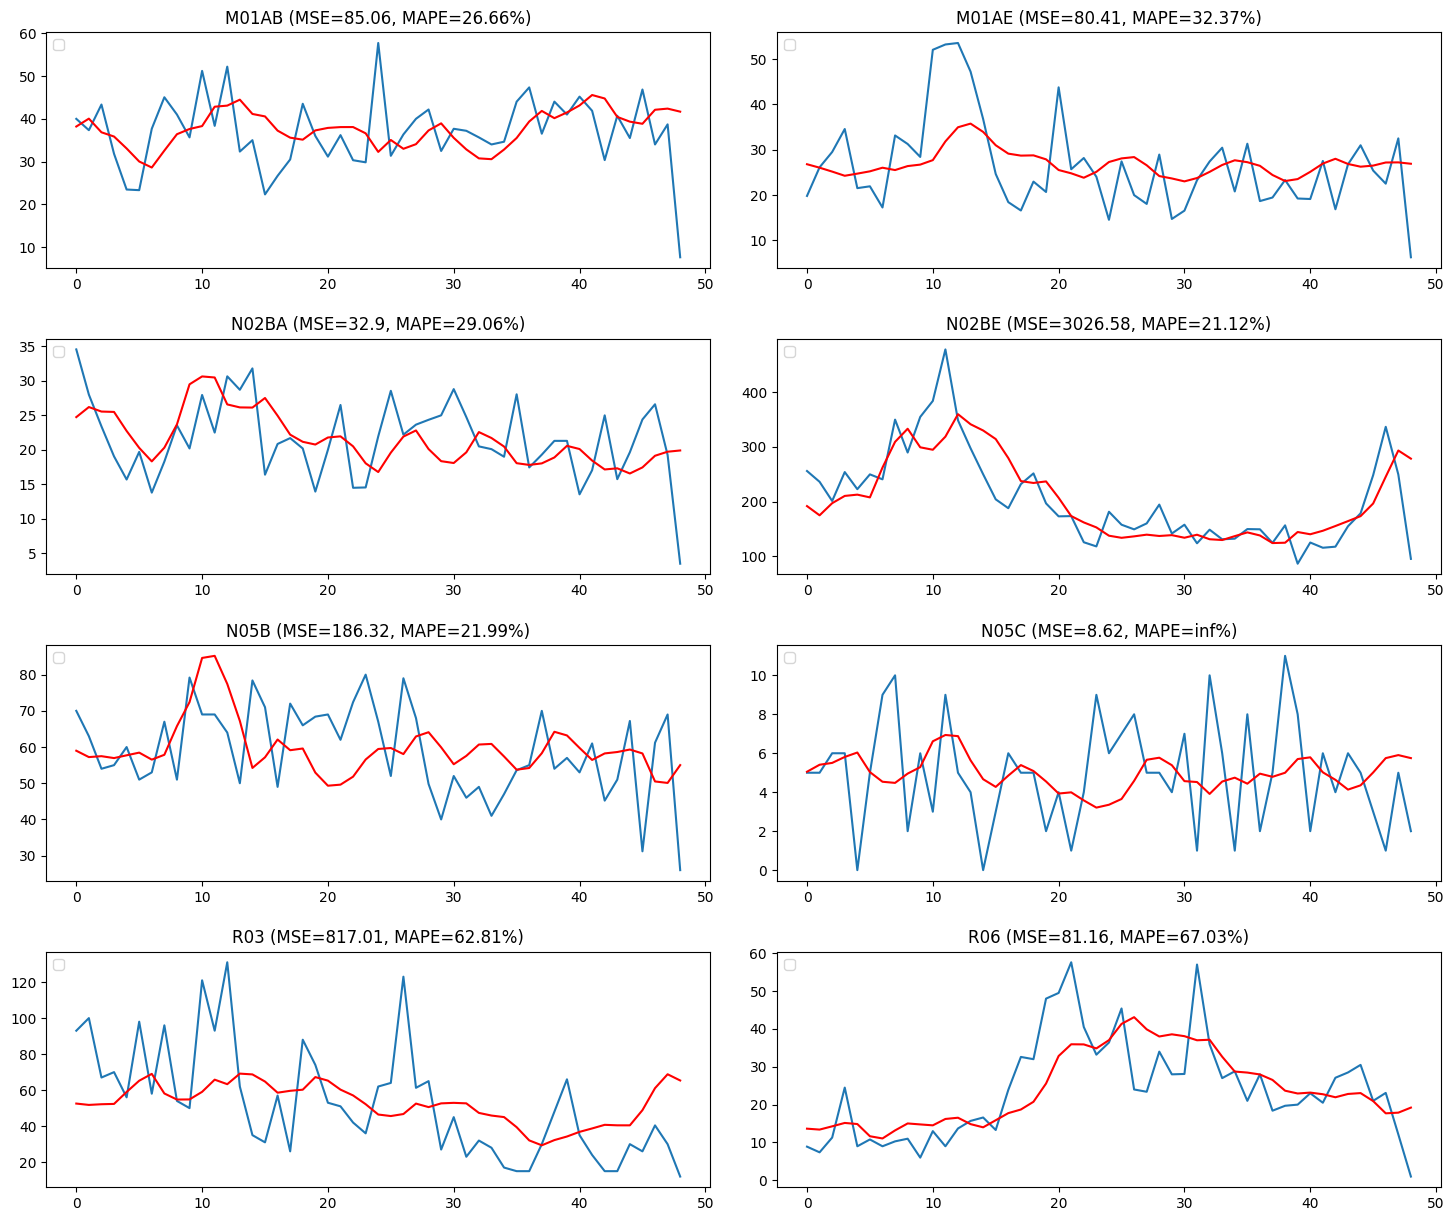

In [44]:
import prophet # Make sure you import prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from IPython.display import display

df = pd.read_csv('/content/salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

M01AB= {'series':'M01AB','params_grid':{'changepoint_prior_scale':30,'interval_width':0.0005}}
M01AE= {'series':'M01AE','params_grid':{'changepoint_prior_scale':0.05,'interval_width':0.0005}}
N02BA= {'series':'N02BA','params_grid':{'changepoint_prior_scale':0.005,'interval_width':0.0005}}
N02BE= {'series':'N02BE','params_grid':{'changepoint_prior_scale':10,'seasonality_prior_scale':170,'interval_width':0.0005}}
N05B= {'series':'N05B','params_grid':{'changepoint_prior_scale':5,'interval_width':0.0005}}
N05C= {'series':'N05C','params_grid':{'changepoint_prior_scale':0.5,'interval_width':0.005}}
R03= {'series':'R03','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':160,'interval_width':0.0005}}
R06= {'series':'R06','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':120,'interval_width':0.0005}}

r=[M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]

for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    dfg=df[['datum',x['series']]]
    dfg = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size = len(dfg) - 50
    dfgtrain=dfg.loc[0:size,:]
    dfgtest=dfg.loc[size+1:len(dfg),:]
    history = dfgtrain.copy()
    predictions = list()

    for t in dfgtest['ds'].values:
        model = prophet.Prophet(changepoint_prior_scale=x['params_grid']['changepoint_prior_scale'],
                                  growth='linear',
                                  interval_width=x['params_grid']['interval_width'],
                                  daily_seasonality=False,
                                  weekly_seasonality=False
                           )
        if(x['series']=='N02BE' or x['series']=='R03' or x['series']=='R06'):
            model=model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                prior_scale=x['params_grid']['seasonality_prior_scale'],
                                fourier_order=13)
        model_fit = model.fit(history)
        future = model.make_future_dataframe(periods=1, freq='W')
        output = model.predict(future)
        yhat = output.loc[output.ds==t]['yhat'].values[0]
        predictions.append(yhat)
        obs = dfgtest.loc[dfgtest.ds==t]['y'].values[0]
        dd=pd.DataFrame([[t,obs]],columns=['ds','y'])
        # Use pd.concat instead of append
        history = pd.concat([history, dd], ignore_index=True)

    error = mean_squared_error(dfgtest['y'].values, predictions)
    perror = mean_absolute_percentage_error(dfgtest['y'].values, predictions)
    resultsRollingdf.loc['Prophet MSE',x['series']]=error
    resultsRollingdf.loc['Prophet MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(dfgtest['y'].values)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### 4.3.3.3. Long-term forecasting with Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/2rcz4lqa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/9ol8whe3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15851', 'data', 'file=/tmp/tmpnlw9mahs/2rcz4lqa.json', 'init=/tmp/tmpnlw9mahs/9ol8whe3.json', 'output', 'file=/tmp/tmpnlw9mahs/prophet_model2_7f4szz/prophet_model-20250302110504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:05:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:05:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/5zdpf86e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnlw9mahs/swv9b5uh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

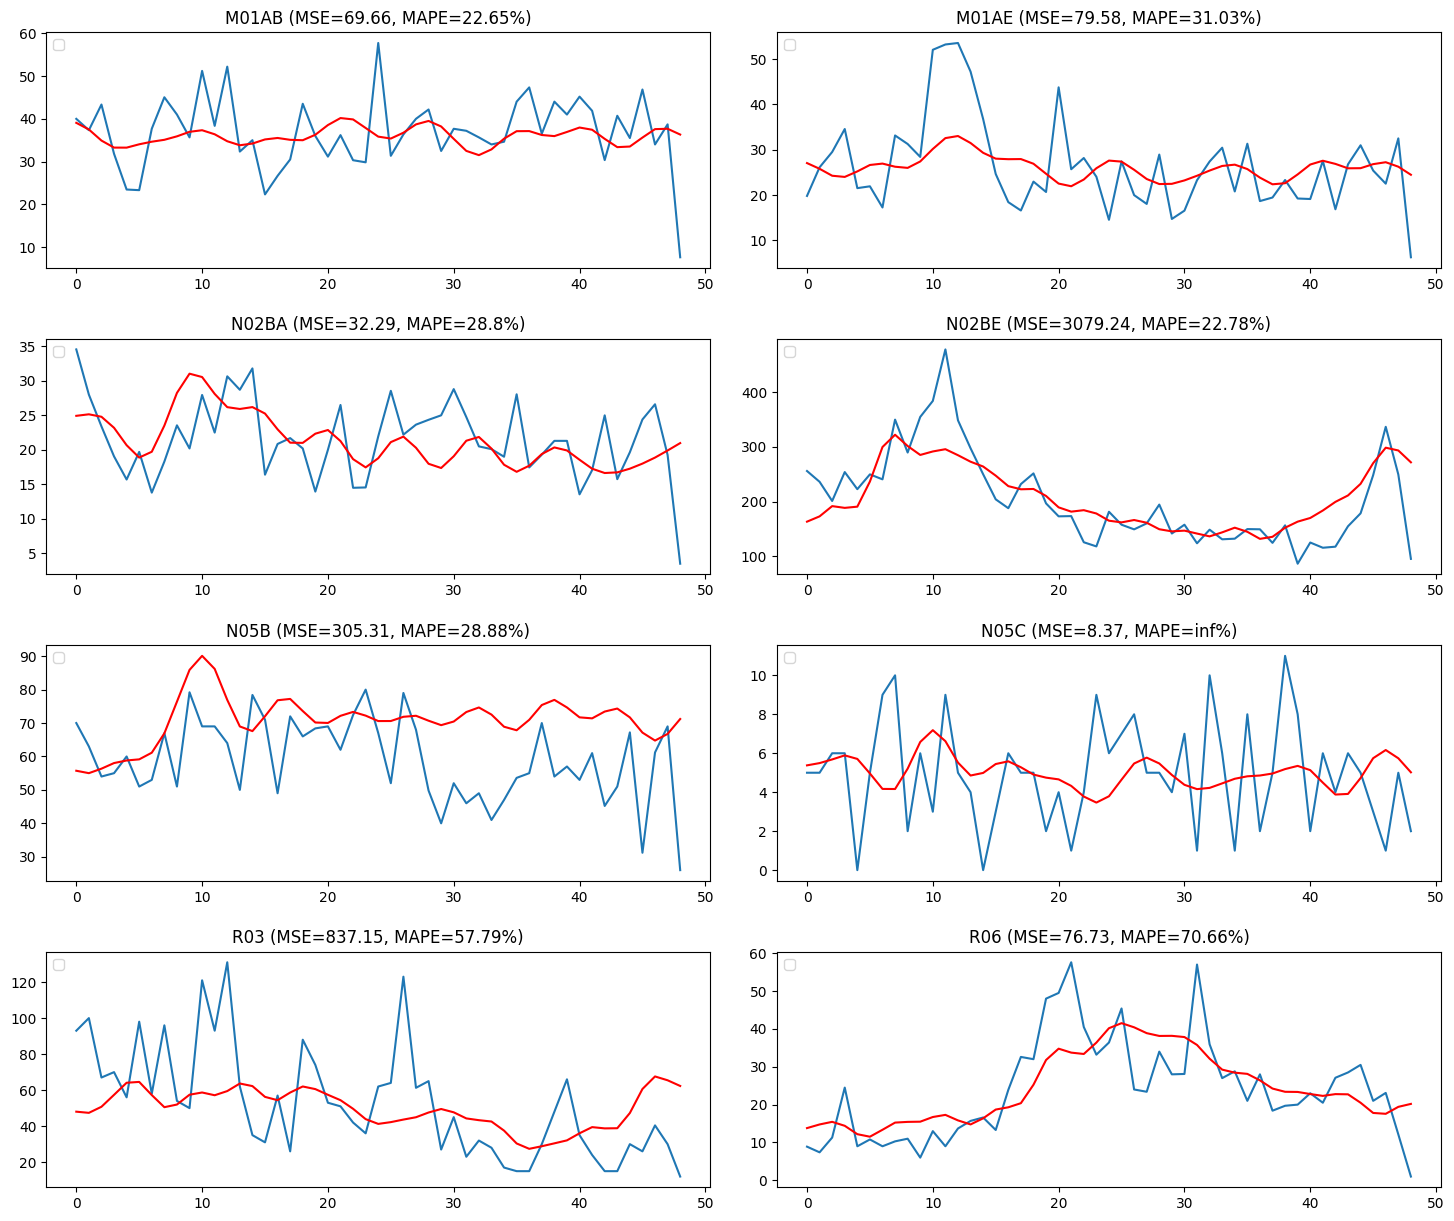

In [46]:
df = pd.read_csv('/content/salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

M01AB= {'series':'M01AB','params_grid':{'changepoint_prior_scale':30,'interval_width':0.0005}}
M01AE= {'series':'M01AE','params_grid':{'changepoint_prior_scale':0.05,'interval_width':0.0005}}
N02BA= {'series':'N02BA','params_grid':{'changepoint_prior_scale':0.005,'interval_width':0.0005}}
N02BE= {'series':'N02BE','params_grid':{'changepoint_prior_scale':10,'seasonality_prior_scale':170,'interval_width':0.0005}}
N05B= {'series':'N05B','params_grid':{'changepoint_prior_scale':5,'interval_width':0.0005}}
N05C= {'series':'N05C','params_grid':{'changepoint_prior_scale':0.5,'interval_width':0.005}}
R03= {'series':'R03','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':160,'interval_width':0.0005}}
R06= {'series':'R06','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':120,'interval_width':0.0005}}

r=[M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]

for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    dfg=df[['datum',x['series']]]
    dfg = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size = int(len(dfg) - 50)
    dfgtrain=dfg.loc[0:size,:]
    dfgtest=dfg.loc[size+1:len(dfg),:]
    predictions = list()
    model = prophet.Prophet(changepoint_prior_scale=x['params_grid']['changepoint_prior_scale'],
                              growth='linear', interval_width=x['params_grid']['interval_width'],
                              daily_seasonality=False,
                              weekly_seasonality=False
                           )
    if(x['series']=='N02BE' or x['series']=='R03' or x['series']=='R06'):
        model=model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                prior_scale=x['params_grid']['seasonality_prior_scale'],
                                fourier_order=13)
    model_fit = model.fit(dfgtrain)
    future = model.make_future_dataframe(periods=50, freq='W')
    output = model.predict(future)
    predictions=output.loc[size+2:len(dfg),:]['yhat'].values

    error = mean_squared_error(dfgtest['y'].values, predictions)
    perror = mean_absolute_percentage_error(dfgtest['y'].values, predictions)
    resultsLongtermdf.loc['Prophet MSE',x['series']]=error
    resultsLongtermdf.loc['Prophet MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(dfgtest['y'].values)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

### 4.3.4. Forecasting with LSTM

Long-term forecasting validation has been done with three LSTM configurations: Vanilla LSTM, Stacked LSTM and Bi-directional LSTM. Relu activation function was used, optimizer was Adam and loss function was Mean Squared Error. The best results were achieved with training the model in 400 epochs. Before fitting, all data was standardized (rescaled in interval -1,1) and transformed to data for supervised problem.

Number of past observations tested in input sequences was either 10 or 5. For series with larger variances and randomness (N05B and N05C) and simpler, Vanilla LSTM model, 10 past observations produced better forecasting accuracy. In all other cases, 5 past observations were used. This is the parameter that has been adopted.

In order to get reproducible results in forecasting with LSTM, following values are fixed: seed value, 'PYTHONHASHSEED' environment variable, Python's, numpy's and Tensorflow's built-in pseudo-random generators. A new global Tensorflow session is configured.

In [49]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

Components required for forecasting with LSTM are then imported. Function split_sequence for transforming time-series data to data for supervised machine learning problem is provided, including constants, such as number of previous steps to take into account.

In [50]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

size = int(len(df) - 50)
n_steps=5
n_features = 1

#### 4.3.4.1. Long-term forecasting with Vanilla LSTM configuration

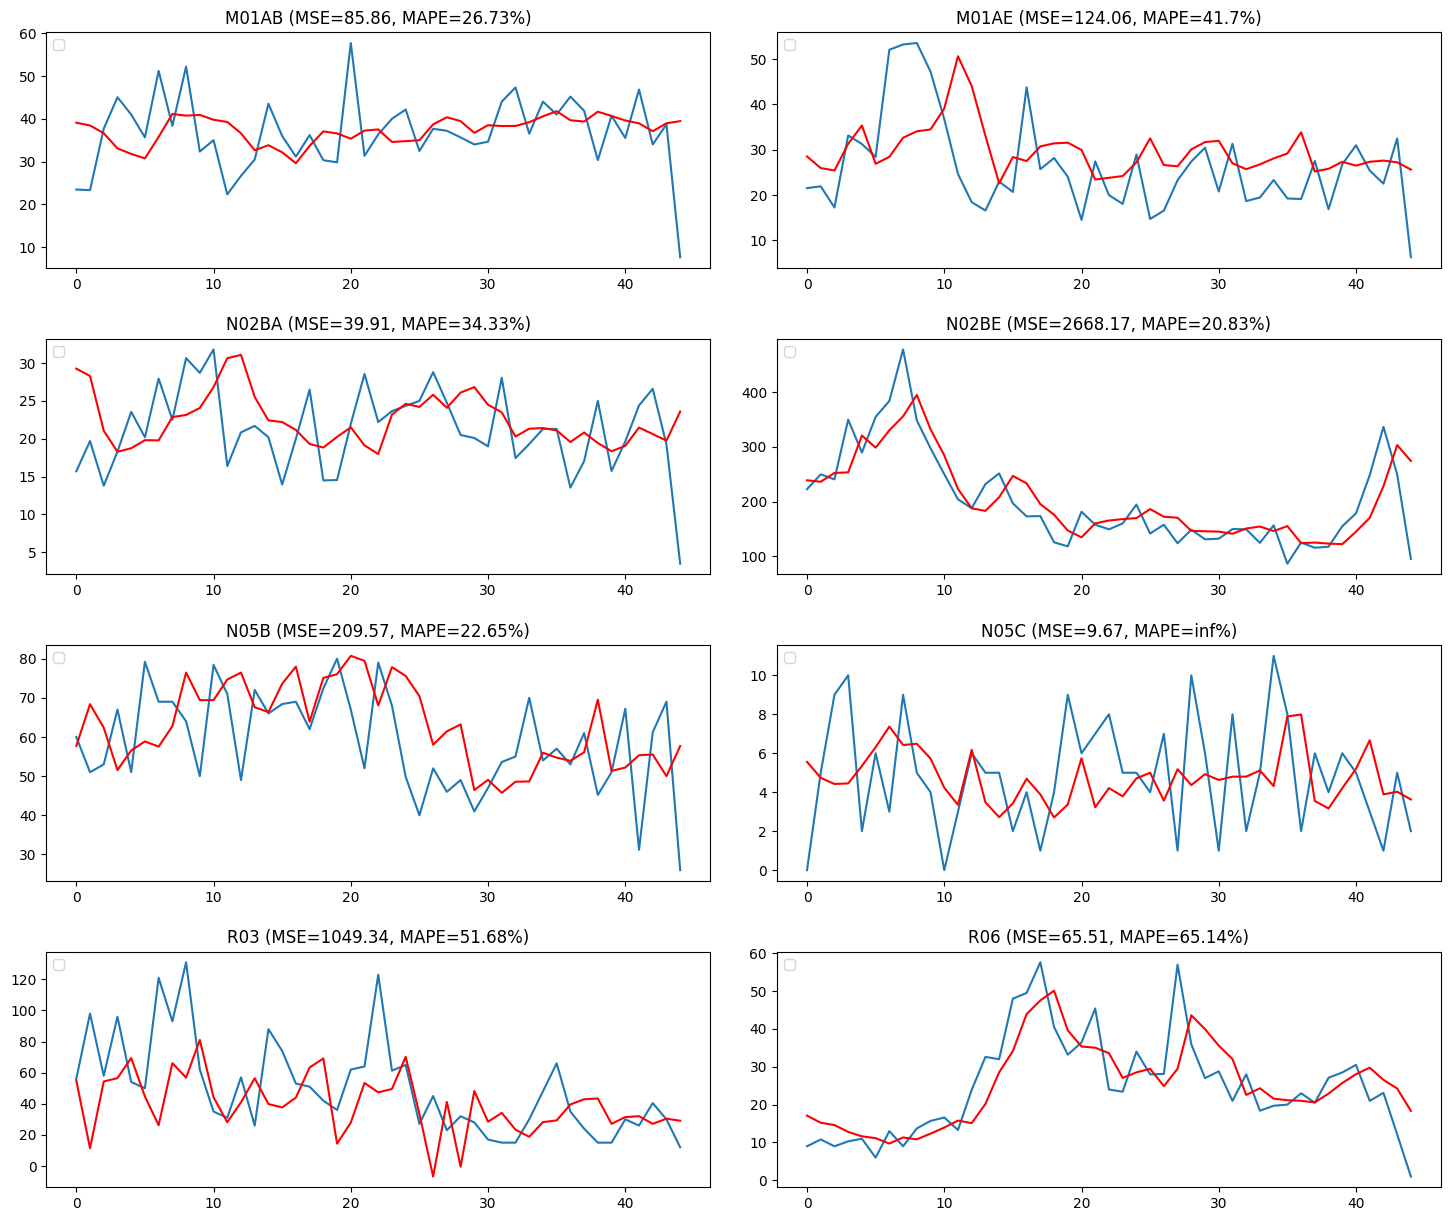

In [51]:
df = pd.read_csv('/content/salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)
    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Vanilla LSTM MSE',x]=error
    resultsLongtermdf.loc['Vanilla LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### 4.3.4.2. Long-term forecasting with Stacked LSTM model

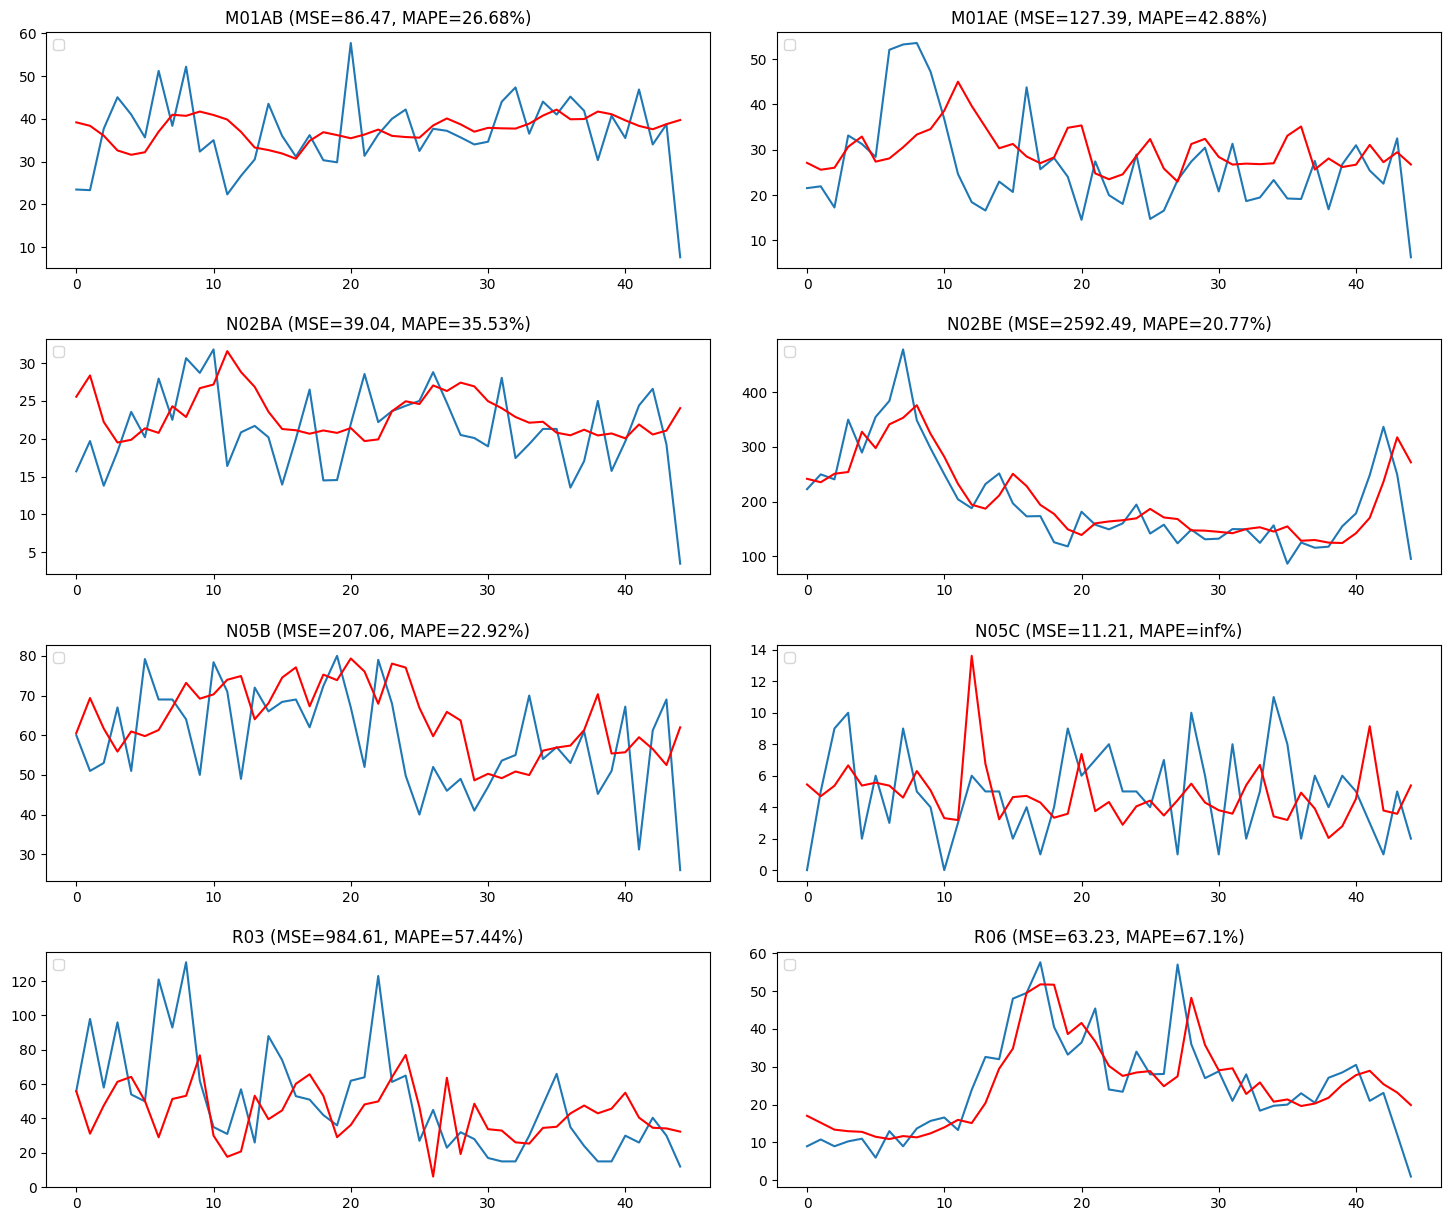

In [52]:
df = pd.read_csv('/content/salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)

    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Stacked LSTM MSE',x]=error
    resultsLongtermdf.loc['Stacked LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### 4.3.4.3. Long-term forecasting with Bidirectional LSTM

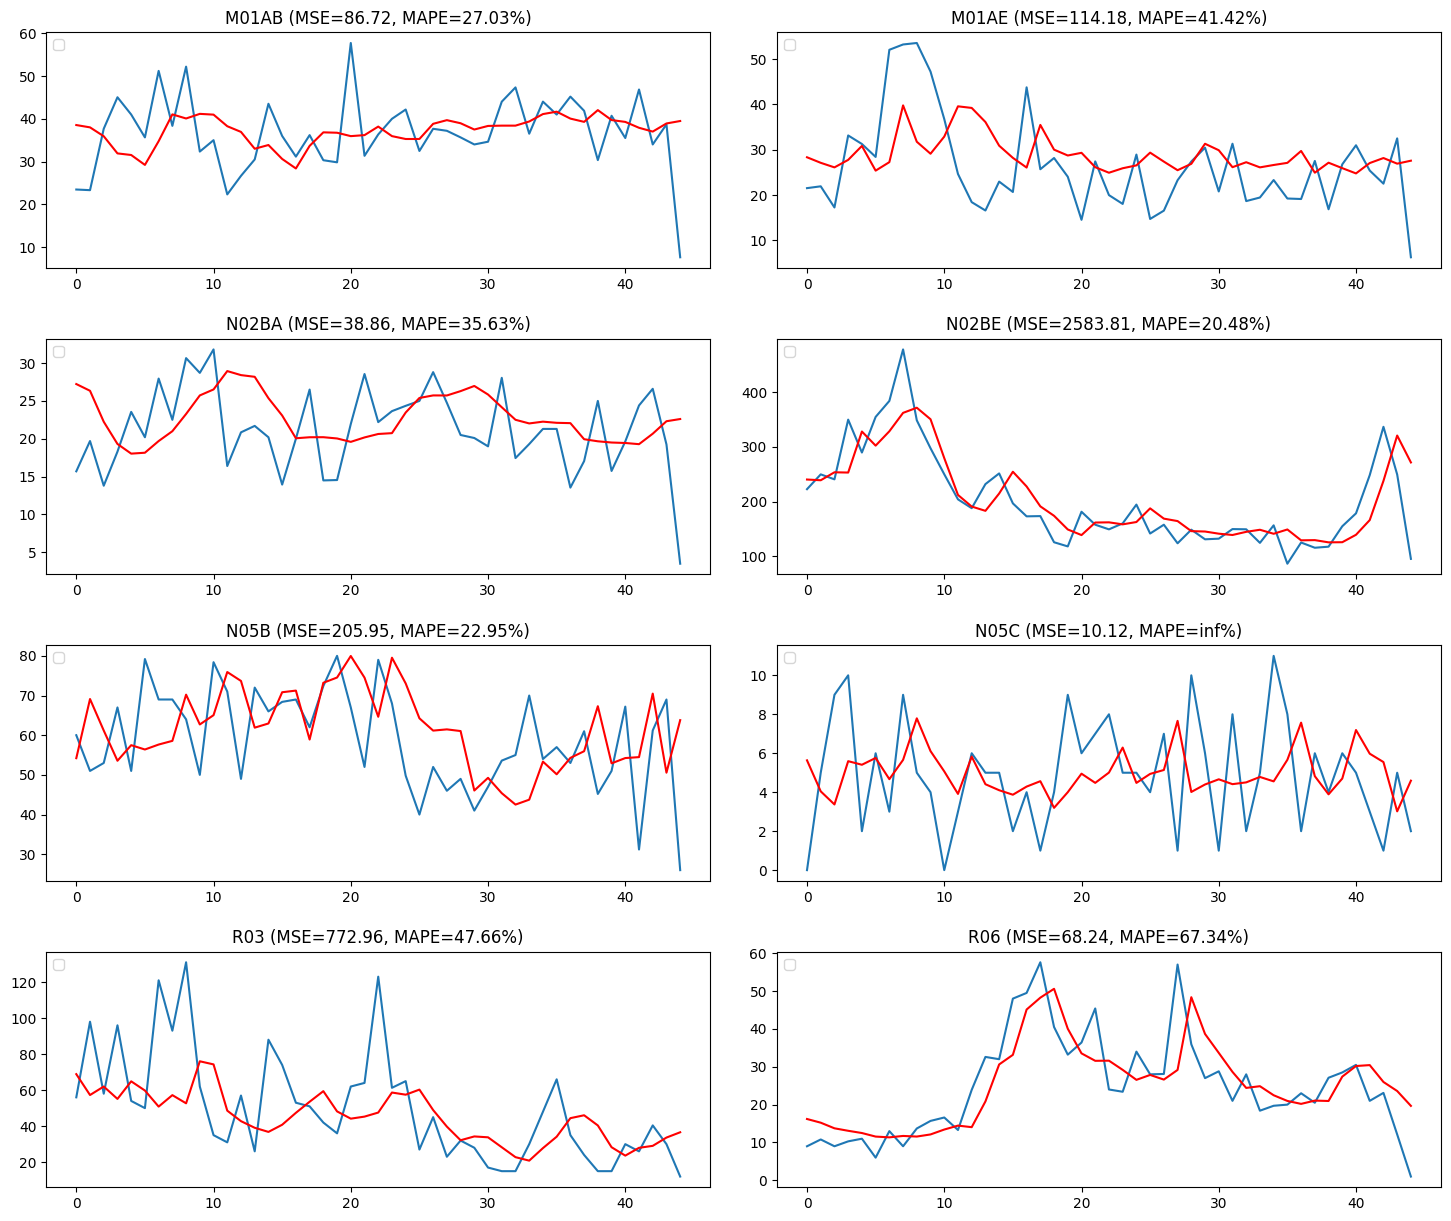

In [53]:
df = pd.read_csv('/content/salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)

    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Bidirectional LSTM MSE',x]=error
    resultsLongtermdf.loc['Bidirectional LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

# 5. Conclusion

For rolling forecast, ARIMA method (Auto-ARIMA for series with seasonal character) outperforms Prophet and is considered as a best candidate for short-term sales forecasting. All methods in all cases (with exception of Prophet N02BE) outperform reference benchmarks - Naive and Seasonal Naive forecasts.

In [54]:
from IPython.display import display, HTML
display(HTML(resultsRollingdf.to_html()))

For long-term forecasting, Prophet and LSTM models have shown significantly better performance then benchmarks in the time series with seasonality. In all cases, even without optimization, LSTM models have achieved competitive performance.

In [55]:
from IPython.display import display, HTML
display(HTML(resultsLongtermdf.to_html()))

To conclude, time-series analyses and forecasts have guided potentially useful conclusions and recommendations to the pharmacy. Daily, weekly and annual seasonality analysis were proven useful for identifying the periods in which special sales and marketing campaigns could be implemented, except for N05B and N05C categories of drugs which did not exhibit significant regularities. Forecasts have proven better than Naïve methods and in acceptable intervals for long-term planning. It is highly likely that the forecasts could be significantly improved by expanding the problem scope to multivariate time series forecasting and by including explanatory variables, such as:
- Weather data. Sales of antirheumatic drugs in M01AB and M01AE categories could be affected by the changes of atmospheric pressure. Sudden declines in all categories could be explained by extreme weather conditions, such as heavy rain, thunderstorms and blizzards.
- Price of the drugs. Sales spikes may be explained by the discounts, applied in a short term. Introducing this feature may facilitate what-if forecasting analysis of sales performance during marketing campaigns involving price reductions.
- Dates of the pension payoff. Sales spikes are visible at the dates of state pensions payoff.
- National holidays, as non-working days with seasonal patterns similar to Sundays are expected to disrupt daily sales.

Future work on univariate time series forecasting includes increasing the number of data, exploring different other accuracy metrics, optimization of hyper-parameters for LSTM models and testing other architectures, such as CNN LSTM and ConvLSTM. However, key improvements in sales forecasting are expected from reducing the uncertainty of the models by expanding to multivariate time series forecasting problem, as explained above.
